### Imports and Data Loading
A Scipy pipeline is used to load the data and convert it into the appropriate Pandas DataFrames for further processing.

In [1]:
# Consolidated Imports
import pandas as pd
import numpy as np
from scipy.io import arff
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
try:
    data, meta = arff.loadarff('data/yeast.arff')
except FileNotFoundError:
    print("Error: 'yeast.arff' not found. Please update the file path.")
    
else:
    # Convert the loaded structured NumPy array to a Pandas DataFrame
    df = pd.DataFrame(data)
    num_features = 103
    
    # X (Features)
    X = df.iloc[:, :num_features]
    # Y (Labels)
    Y = df.iloc[:, num_features:] 

    # Some ARFF files (especially from Mulan) might read binary columns as 'b' type (bytes), 
    # so we often need to convert to integer (0 or 1).
    for col in Y.columns:
        if Y[col].dtype == 'object':
            Y[col] = Y[col].apply(lambda x: 1 if x == b'1' else 0)

# ----------------------------------------------------------------------
# 2. Display Dimensionality Check (as required by Part A, Step 2)
# ----------------------------------------------------------------------
print(f"Shape of Feature Matrix X: {X.shape}")
print(f"Initial Number of Features: {X.shape[1]}")
print(f"Number of Data Points: {X.shape[0]}")
print(f"Shape of Label Matrix Y: {Y.shape}")

Shape of Feature Matrix X: (2417, 103)
Initial Number of Features: 103
Number of Data Points: 2417
Shape of Label Matrix Y: (2417, 14)


### Preprocessing
The labels are analysed to find the 2 most frequent single labels and the most common multi labels.


In [3]:
# Sum of the row indicates the number of active labels (1 for single, >1 for multi)
label_sums = Y.sum(axis=1)

# Convert each binary label row into a hashable string (e.g., '00101...')
# This allows us to count the unique combinations (patterns)
label_patterns = [''.join(map(str, row)) for row in Y.values]
pattern_counts = Counter(label_patterns)

# Create a DataFrame for easy analysis
pattern_df = pd.DataFrame({
    'pattern_str': label_patterns,
    'label_count': label_sums
})


# ----------------------------------------------------------------------
# 2. Identify Target Categories
# ----------------------------------------------------------------------

# A. Find the two most frequent SINGLE-label patterns (label_count == 1)
single_label_patterns = pattern_df[pattern_df['label_count'] == 1]['pattern_str'].value_counts()
top_single_labels = single_label_patterns.nlargest(2).index.tolist()

if len(top_single_labels) < 2:
    print("Warning: Less than two single-label classes found. Using available ones.")

# B. Find the most frequent MULTI-label pattern (label_count > 1)
multi_label_patterns = pattern_df[pattern_df['label_count'] > 1]['pattern_str'].value_counts()
top_multi_label = multi_label_patterns.nlargest(1).index.tolist()

# If no multi-label combination exists (highly unlikely for multi-label data)
if not top_multi_label:
    print("Error: No multi-label combinations found in the dataset.")
    top_multi_label = []

# Combine the selected patterns
selected_patterns = top_single_labels + top_multi_label
selected_patterns = [p for p in selected_patterns if p] # Remove any empty strings

print(f"Top 2 Single-Label Patterns Selected: {top_single_labels}")
print(f"Top 1 Multi-Label Pattern Selected: {top_multi_label}")


# ----------------------------------------------------------------------
# 3. Create the Final Categorical Index for Coloring
# ----------------------------------------------------------------------

def map_pattern_to_color_label(pattern):
    """Maps a label pattern to one of the four final visualization categories."""
    if pattern == top_single_labels[0]:
        return "SL-1" # Single Label 1
    elif len(top_single_labels) > 1 and pattern == top_single_labels[1]:
        return "SL-2" # Single Label 2
    elif len(top_multi_label) > 0 and pattern == top_multi_label[0]:
        return "ML-1" # Multi Label 1
    else:
        return "Other"

# Apply the mapping to the entire dataset
coloring_index = pd.Series(label_patterns).apply(map_pattern_to_color_label)

print("\n--- Final Coloring Index Distribution ---")
print(coloring_index.value_counts())

Top 2 Single-Label Patterns Selected: ['10000000000000']
Top 1 Multi-Label Pattern Selected: ['00110000000110']

--- Final Coloring Index Distribution ---
Other    2148
ML-1      237
SL-1       32
Name: count, dtype: int64


As visible, there is only one kind of single label, which has been detected and relabeled as SL-1. The most frequent multilabel is detected and assigned as ML-1. Every other datapoint has been labelled as 'Other'.

In [4]:
Y_new = coloring_index.copy()

In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Apply Standardization (fit and transform)
X_scaled = scaler.fit_transform(X)

print("StandardScaler initialized and applied.")
print(f"Original X shape: {X.shape}")
print(f"Scaled X shape: {X_scaled.shape}")
print(f"Mean of first feature after scaling: {np.mean(X_scaled[:, 0])}")
print(f"Std Dev of first feature after scaling: {np.std(X_scaled[:, 0])}")

StandardScaler initialized and applied.
Original X shape: (2417, 103)
Scaled X shape: (2417, 103)
Mean of first feature after scaling: 1.9843456625488937e-17
Std Dev of first feature after scaling: 1.0


### Why Standardization is crucial 
These techniques rely on calculating the Euclidean distance between data points in the original 86-dimensional space. 

If features are left unscaled, features with naturally larger numeric ranges or standard deviations will contribute disproportionately more to the distance calculation than features with smaller ranges. The dimensionality reduction would effectively be dominated by only a few "loud" features. The resulting separation in the 2D plot would reflect differences in magnitude rather than underlying informational content, leading to misleading clusters.

Standardization (Z-score scaling) transforms the data such that each feature has a mean of 0 and a standard deviation of 1. This ensures that all 103 features are treated equally in the distance metric, nullifying biases based on feature magnitudes.

In [6]:
perplexities = [i for i in range(10, 101, 10)]
tsne_results = {}
RANDOM_STATE = 42 # For reproducibility

print("--- Experimenting with t-SNE Perplexity ---")

# Run t-SNE for each perplexity value
for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, random_state=RANDOM_STATE, n_jobs=-1, learning_rate='auto', init='random')
    print(f"Running t-SNE with perplexity={p}...")
    X_tsne = tsne.fit_transform(X_scaled)
    tsne_results[p] = X_tsne
    print(f"Completed run for P={p}. Shape: {X_tsne.shape}")



--- Experimenting with t-SNE Perplexity ---
Running t-SNE with perplexity=10...
Completed run for P=10. Shape: (2417, 2)
Running t-SNE with perplexity=20...
Completed run for P=10. Shape: (2417, 2)
Running t-SNE with perplexity=20...
Completed run for P=20. Shape: (2417, 2)
Running t-SNE with perplexity=30...
Completed run for P=20. Shape: (2417, 2)
Running t-SNE with perplexity=30...
Completed run for P=30. Shape: (2417, 2)
Running t-SNE with perplexity=40...
Completed run for P=30. Shape: (2417, 2)
Running t-SNE with perplexity=40...
Completed run for P=40. Shape: (2417, 2)
Running t-SNE with perplexity=50...
Completed run for P=40. Shape: (2417, 2)
Running t-SNE with perplexity=50...
Completed run for P=50. Shape: (2417, 2)
Running t-SNE with perplexity=60...
Completed run for P=50. Shape: (2417, 2)
Running t-SNE with perplexity=60...
Completed run for P=60. Shape: (2417, 2)
Running t-SNE with perplexity=70...
Completed run for P=60. Shape: (2417, 2)
Running t-SNE with perplexity=70

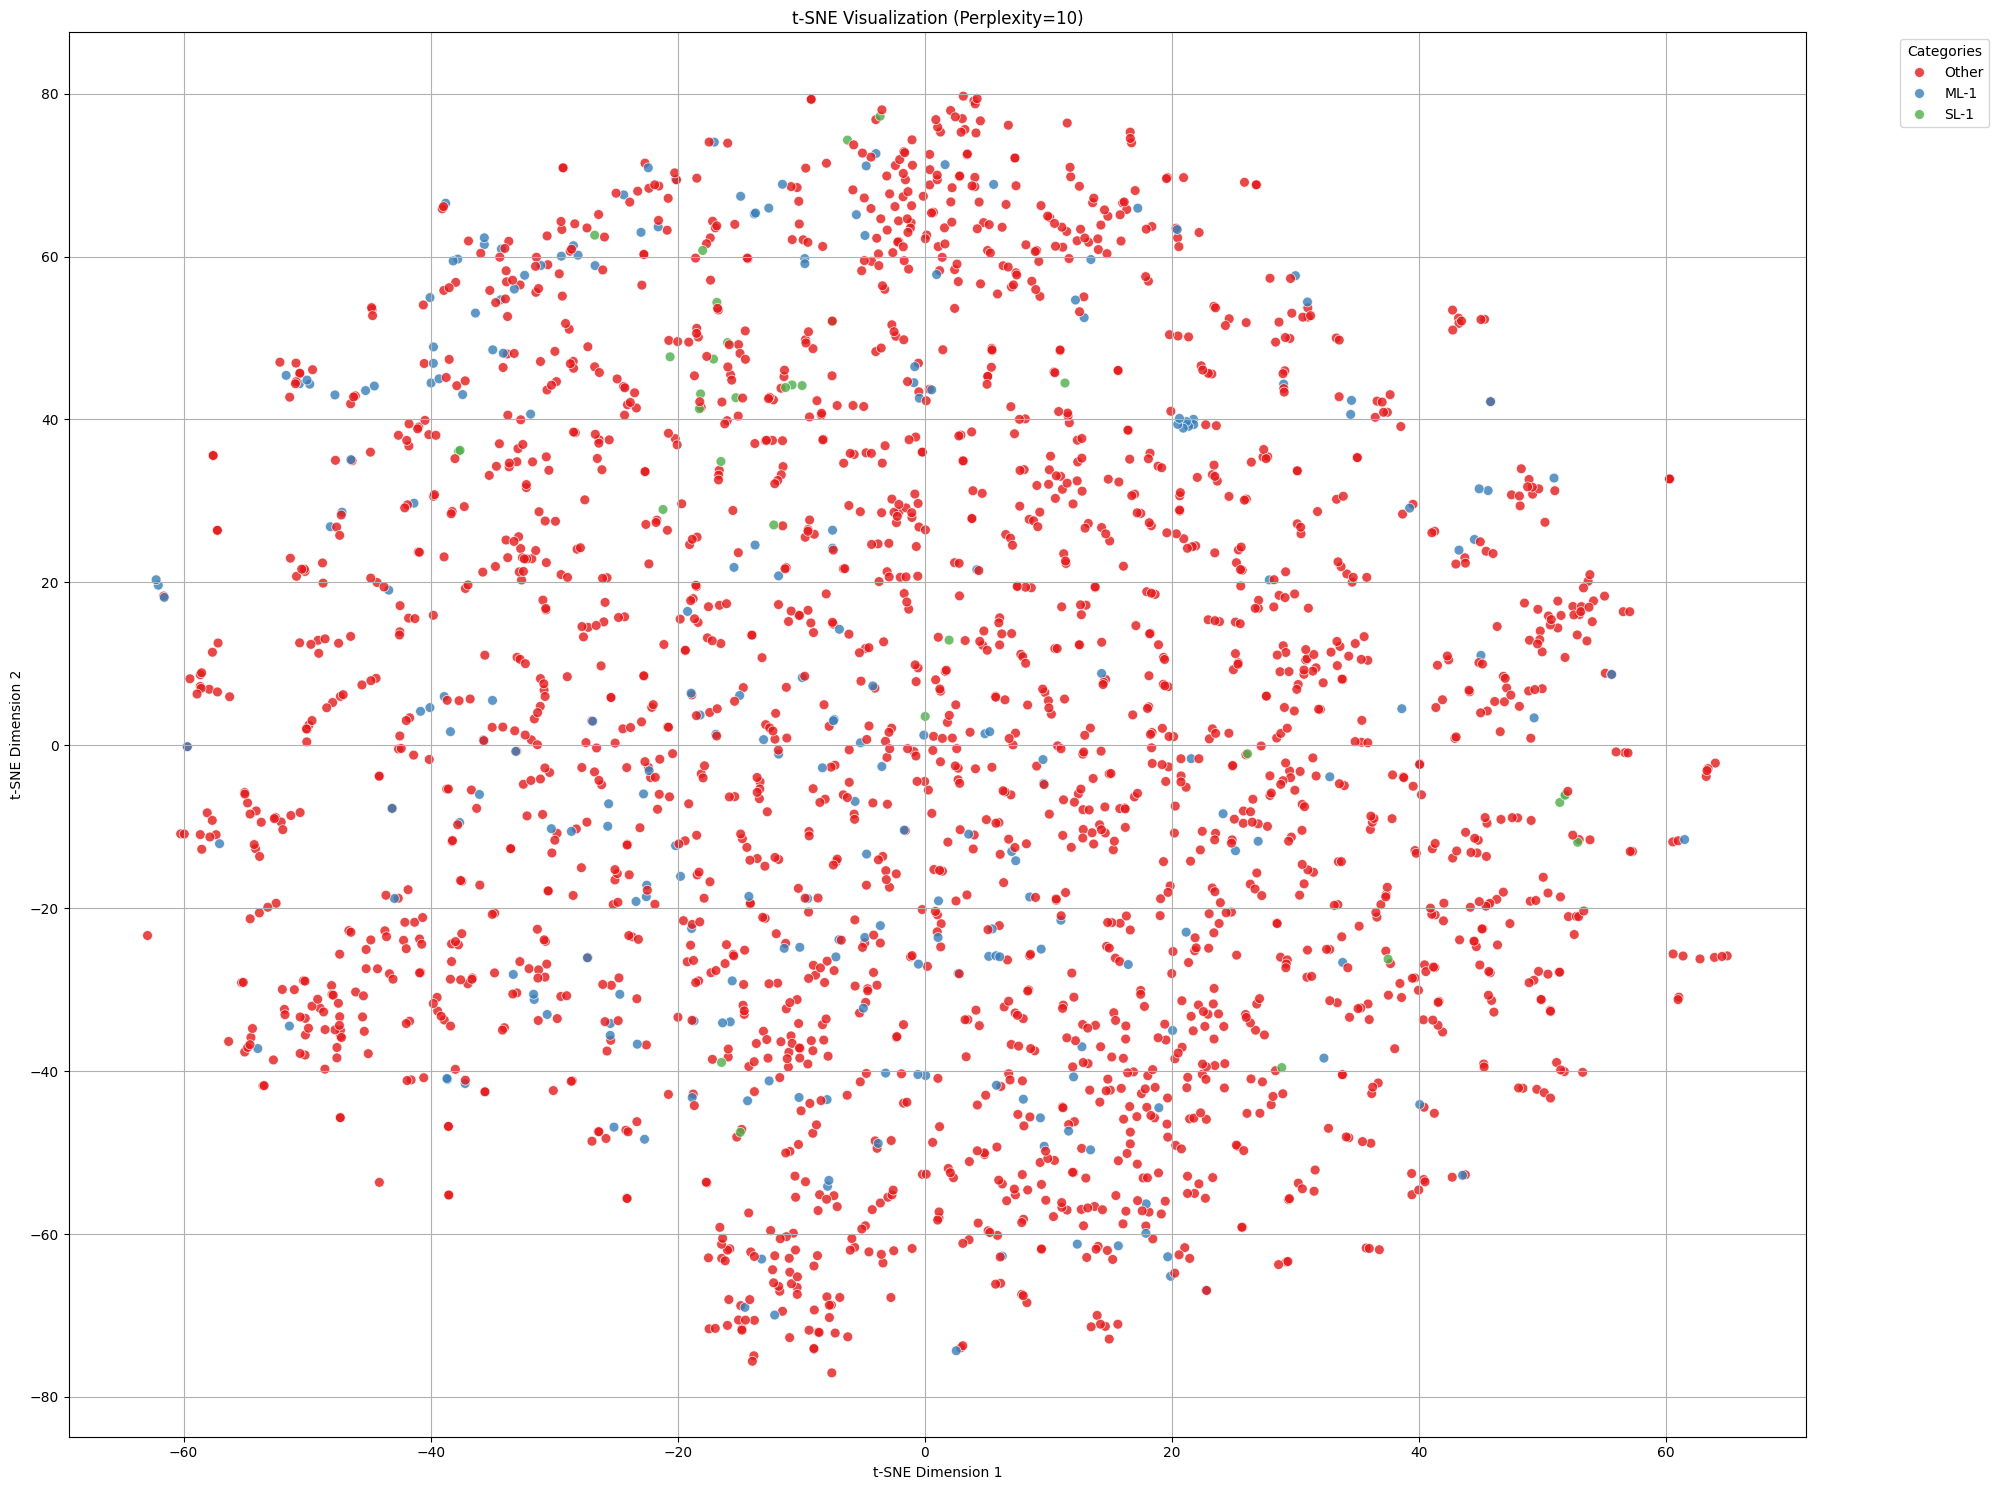

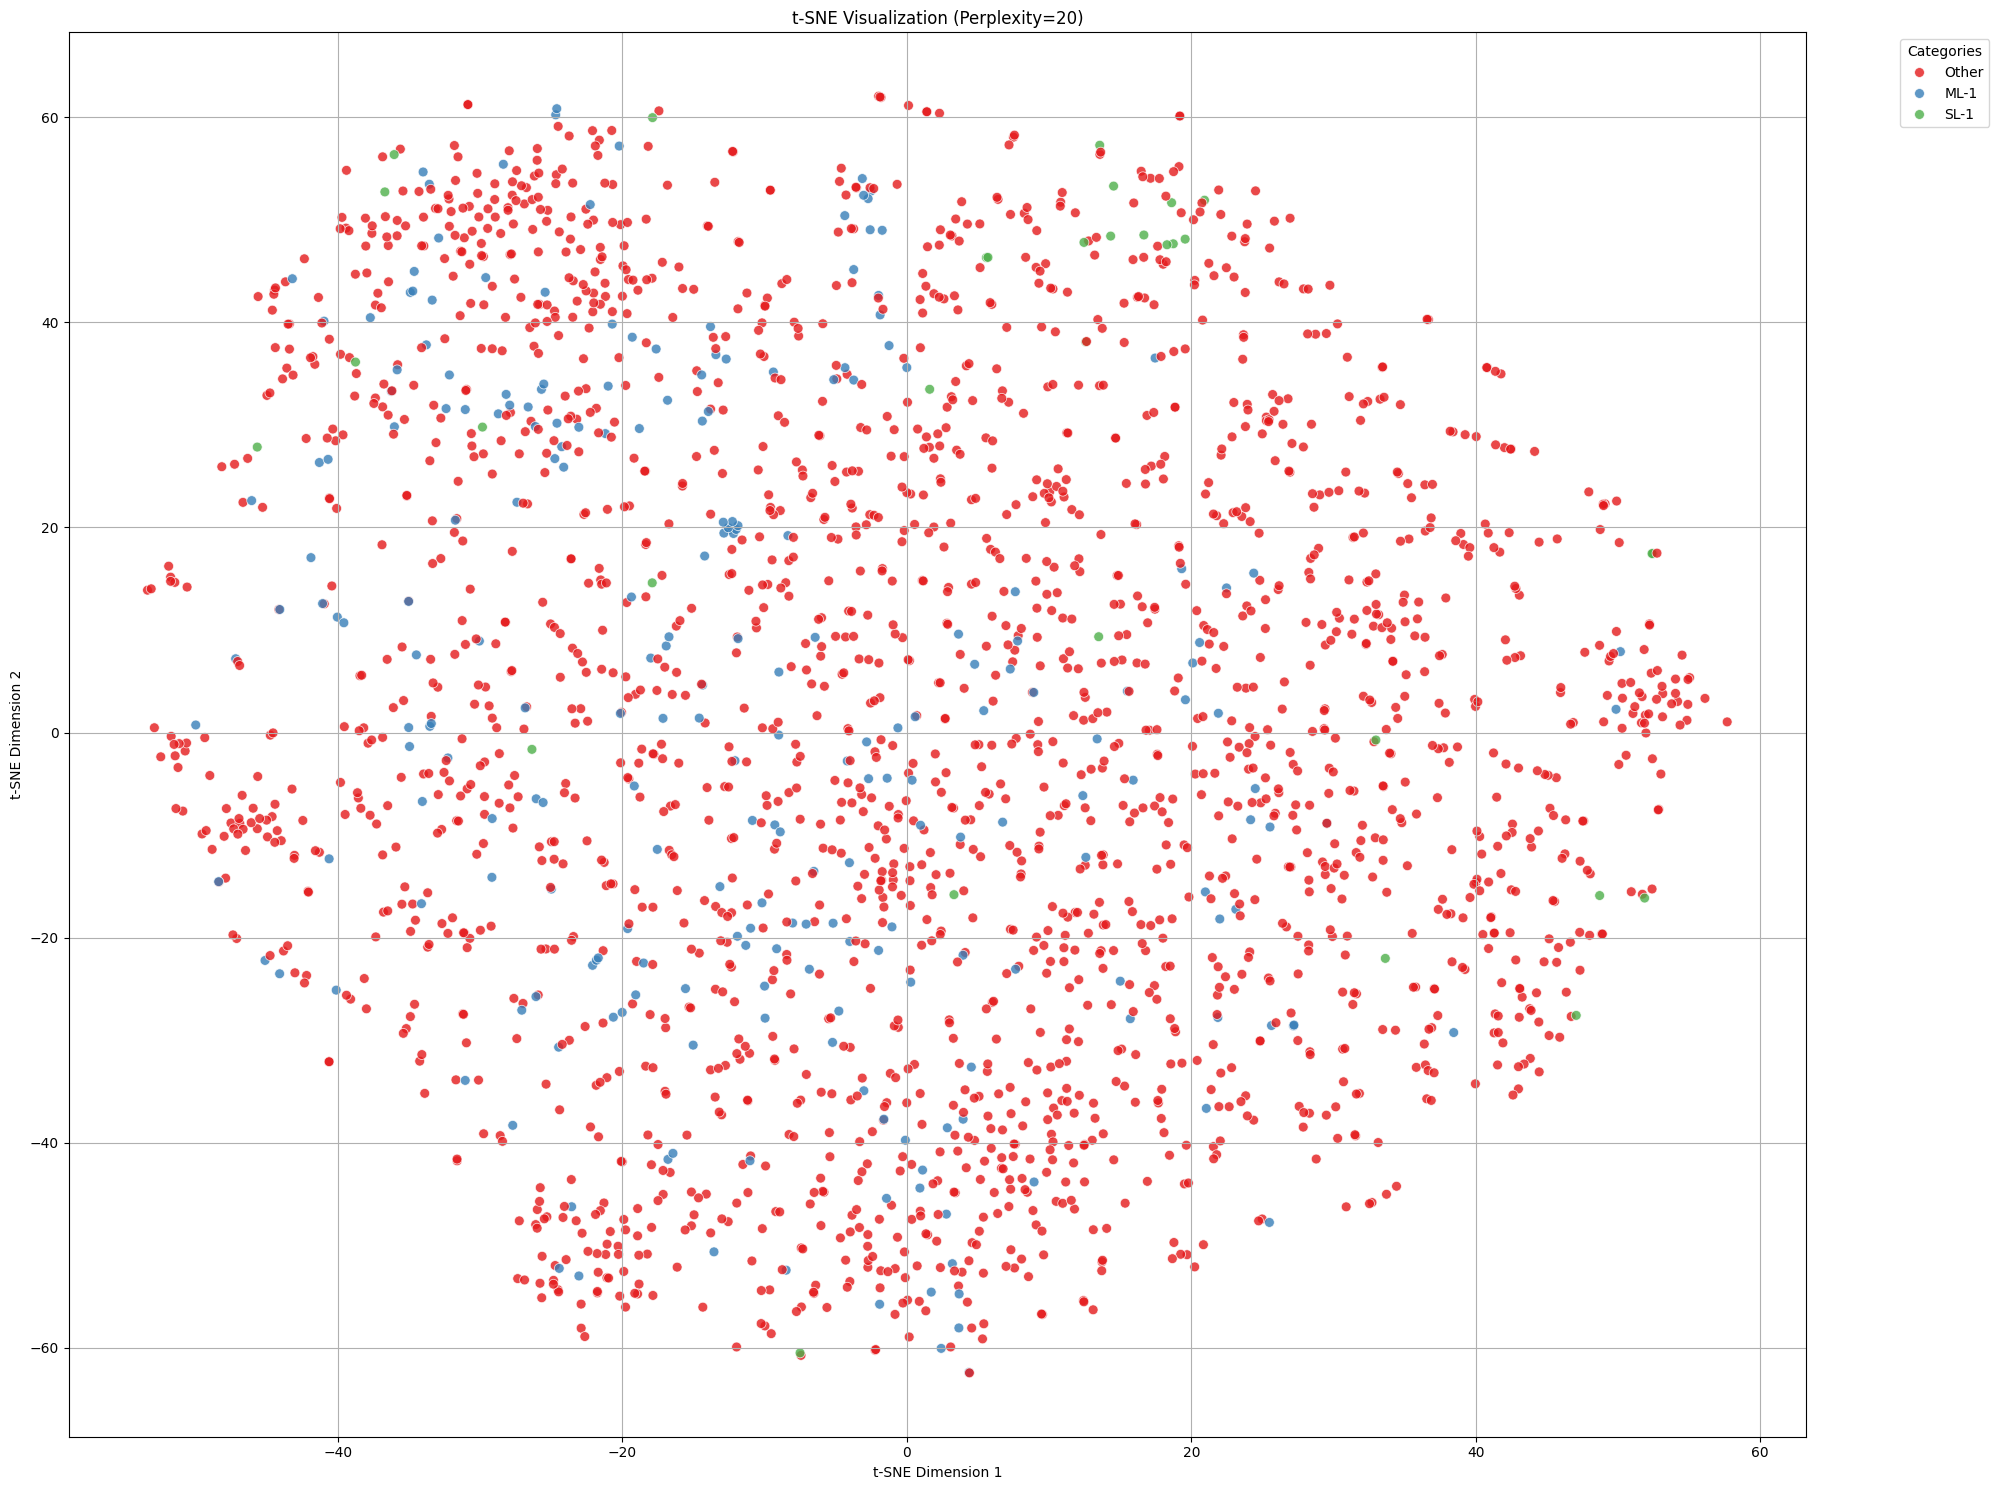

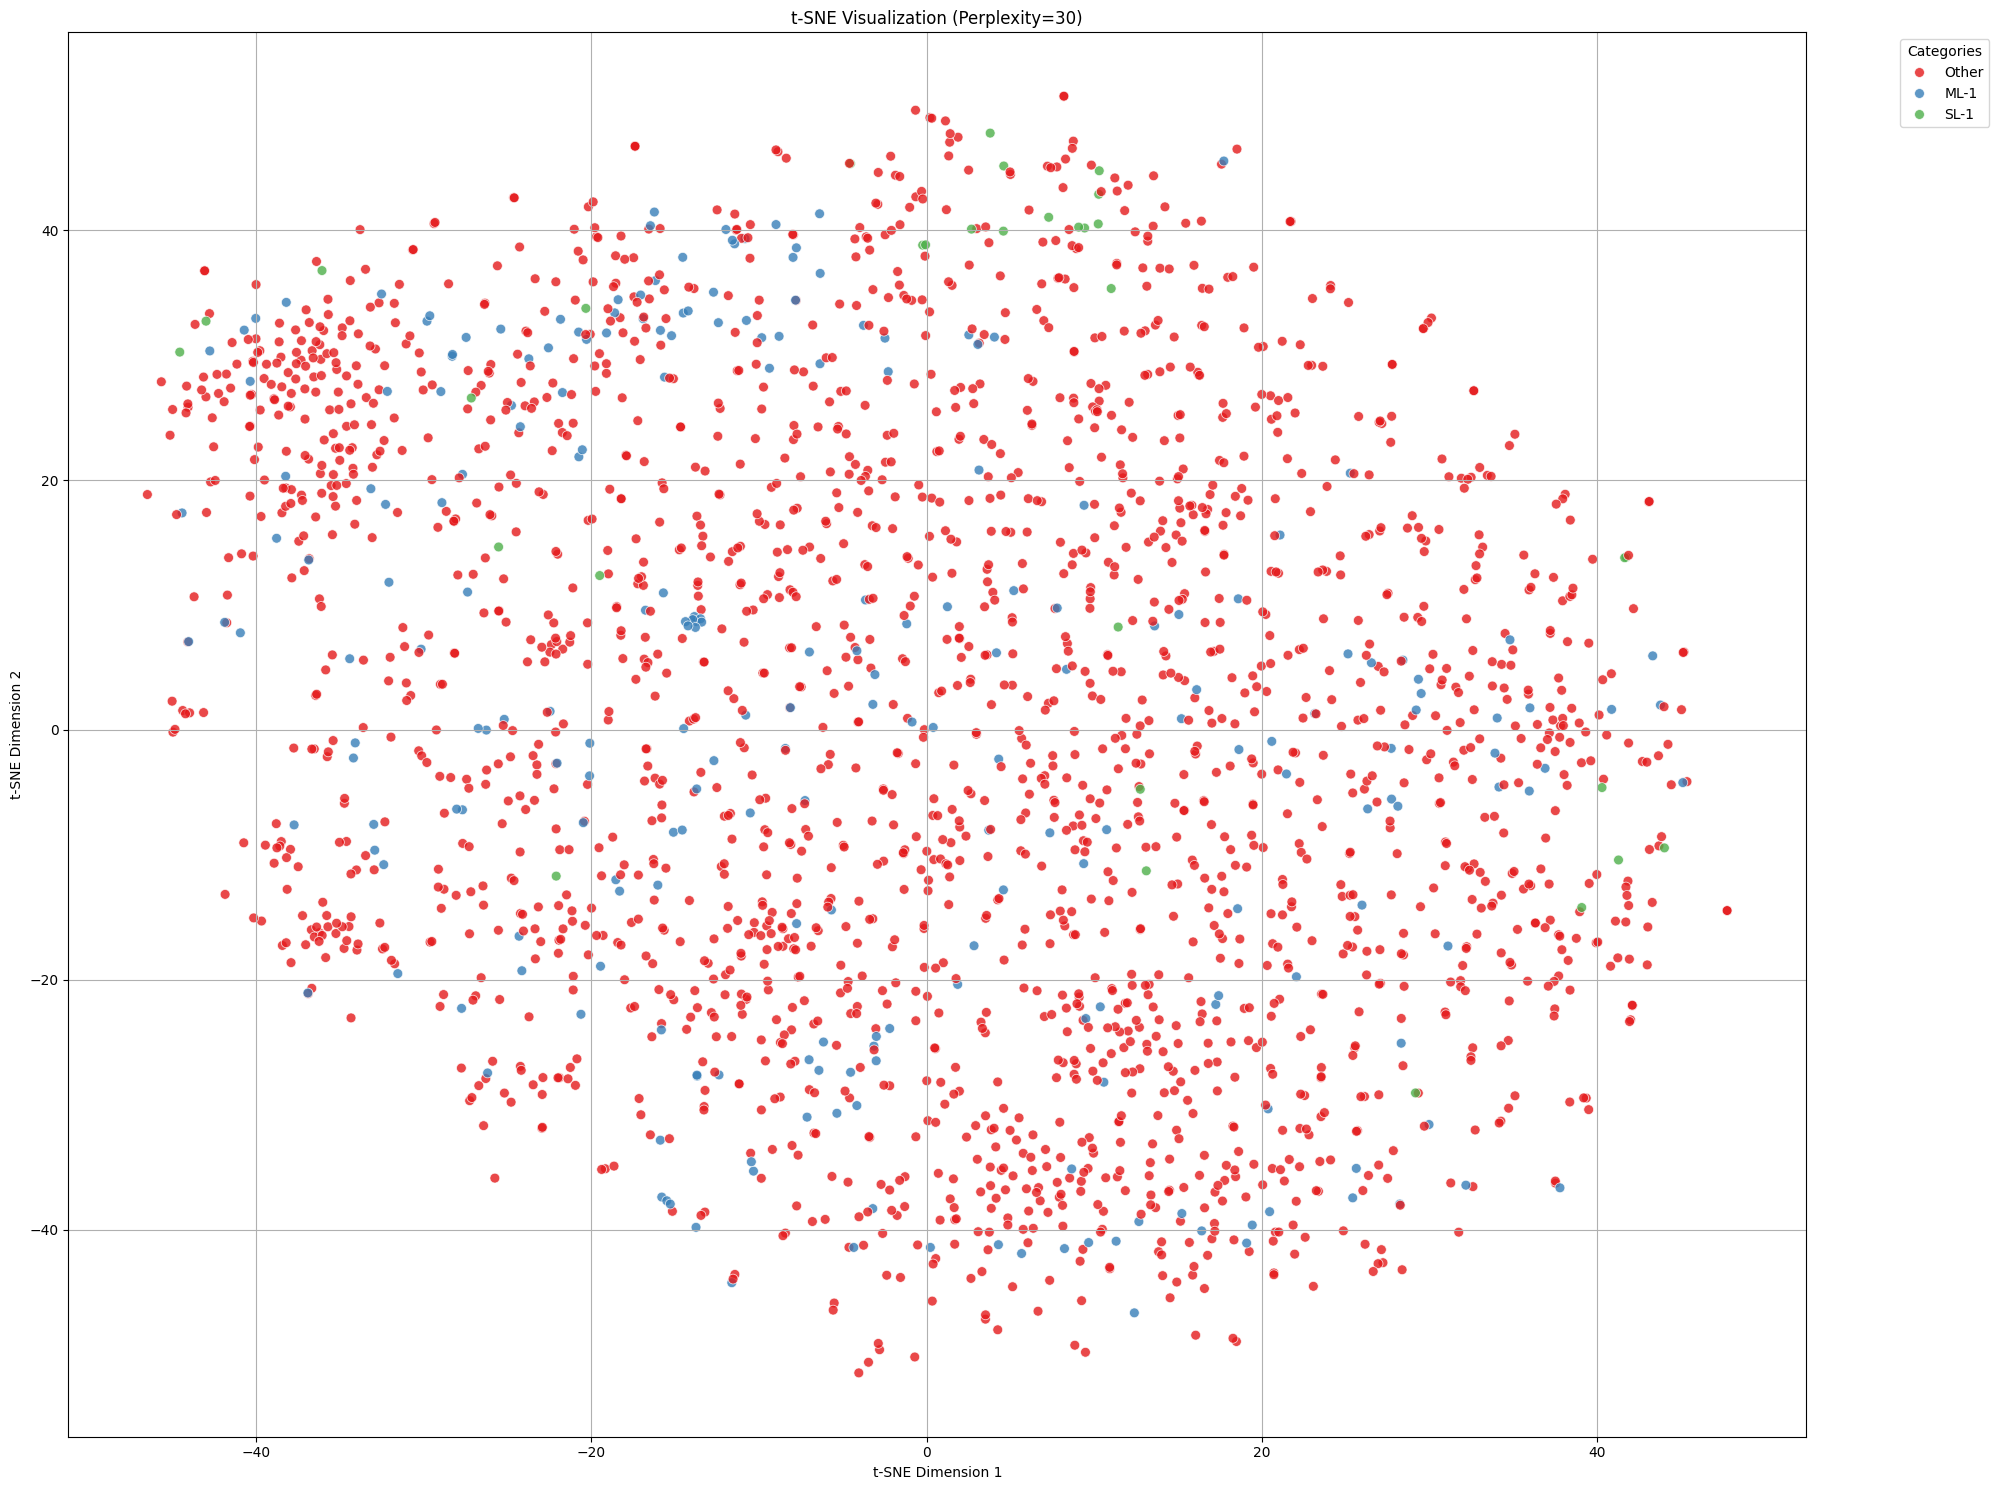

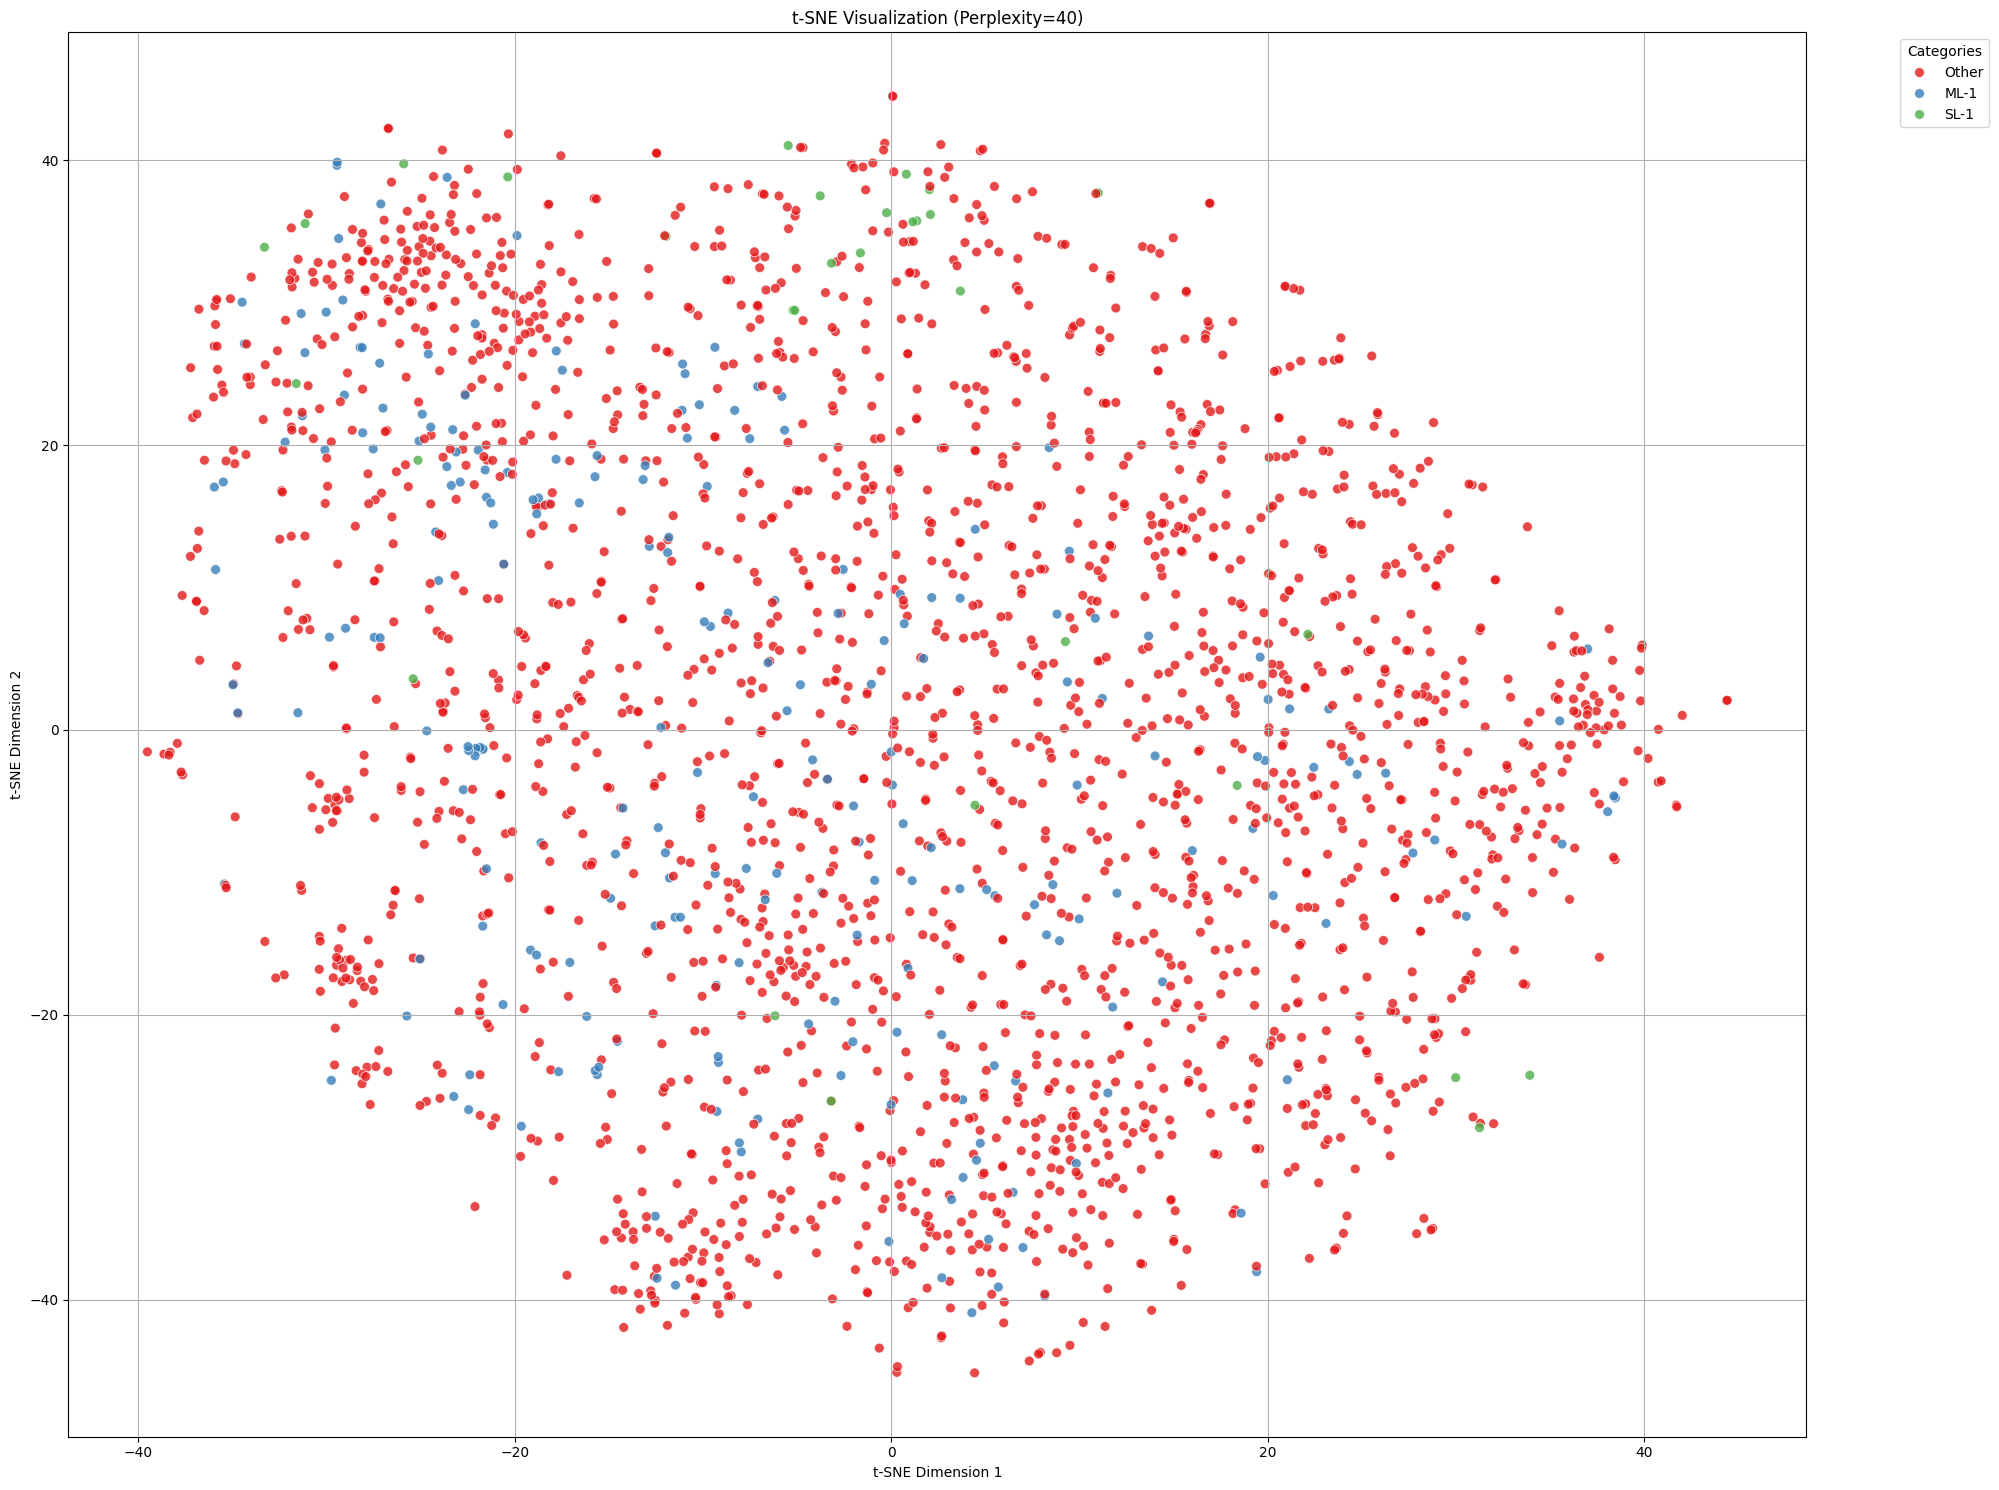

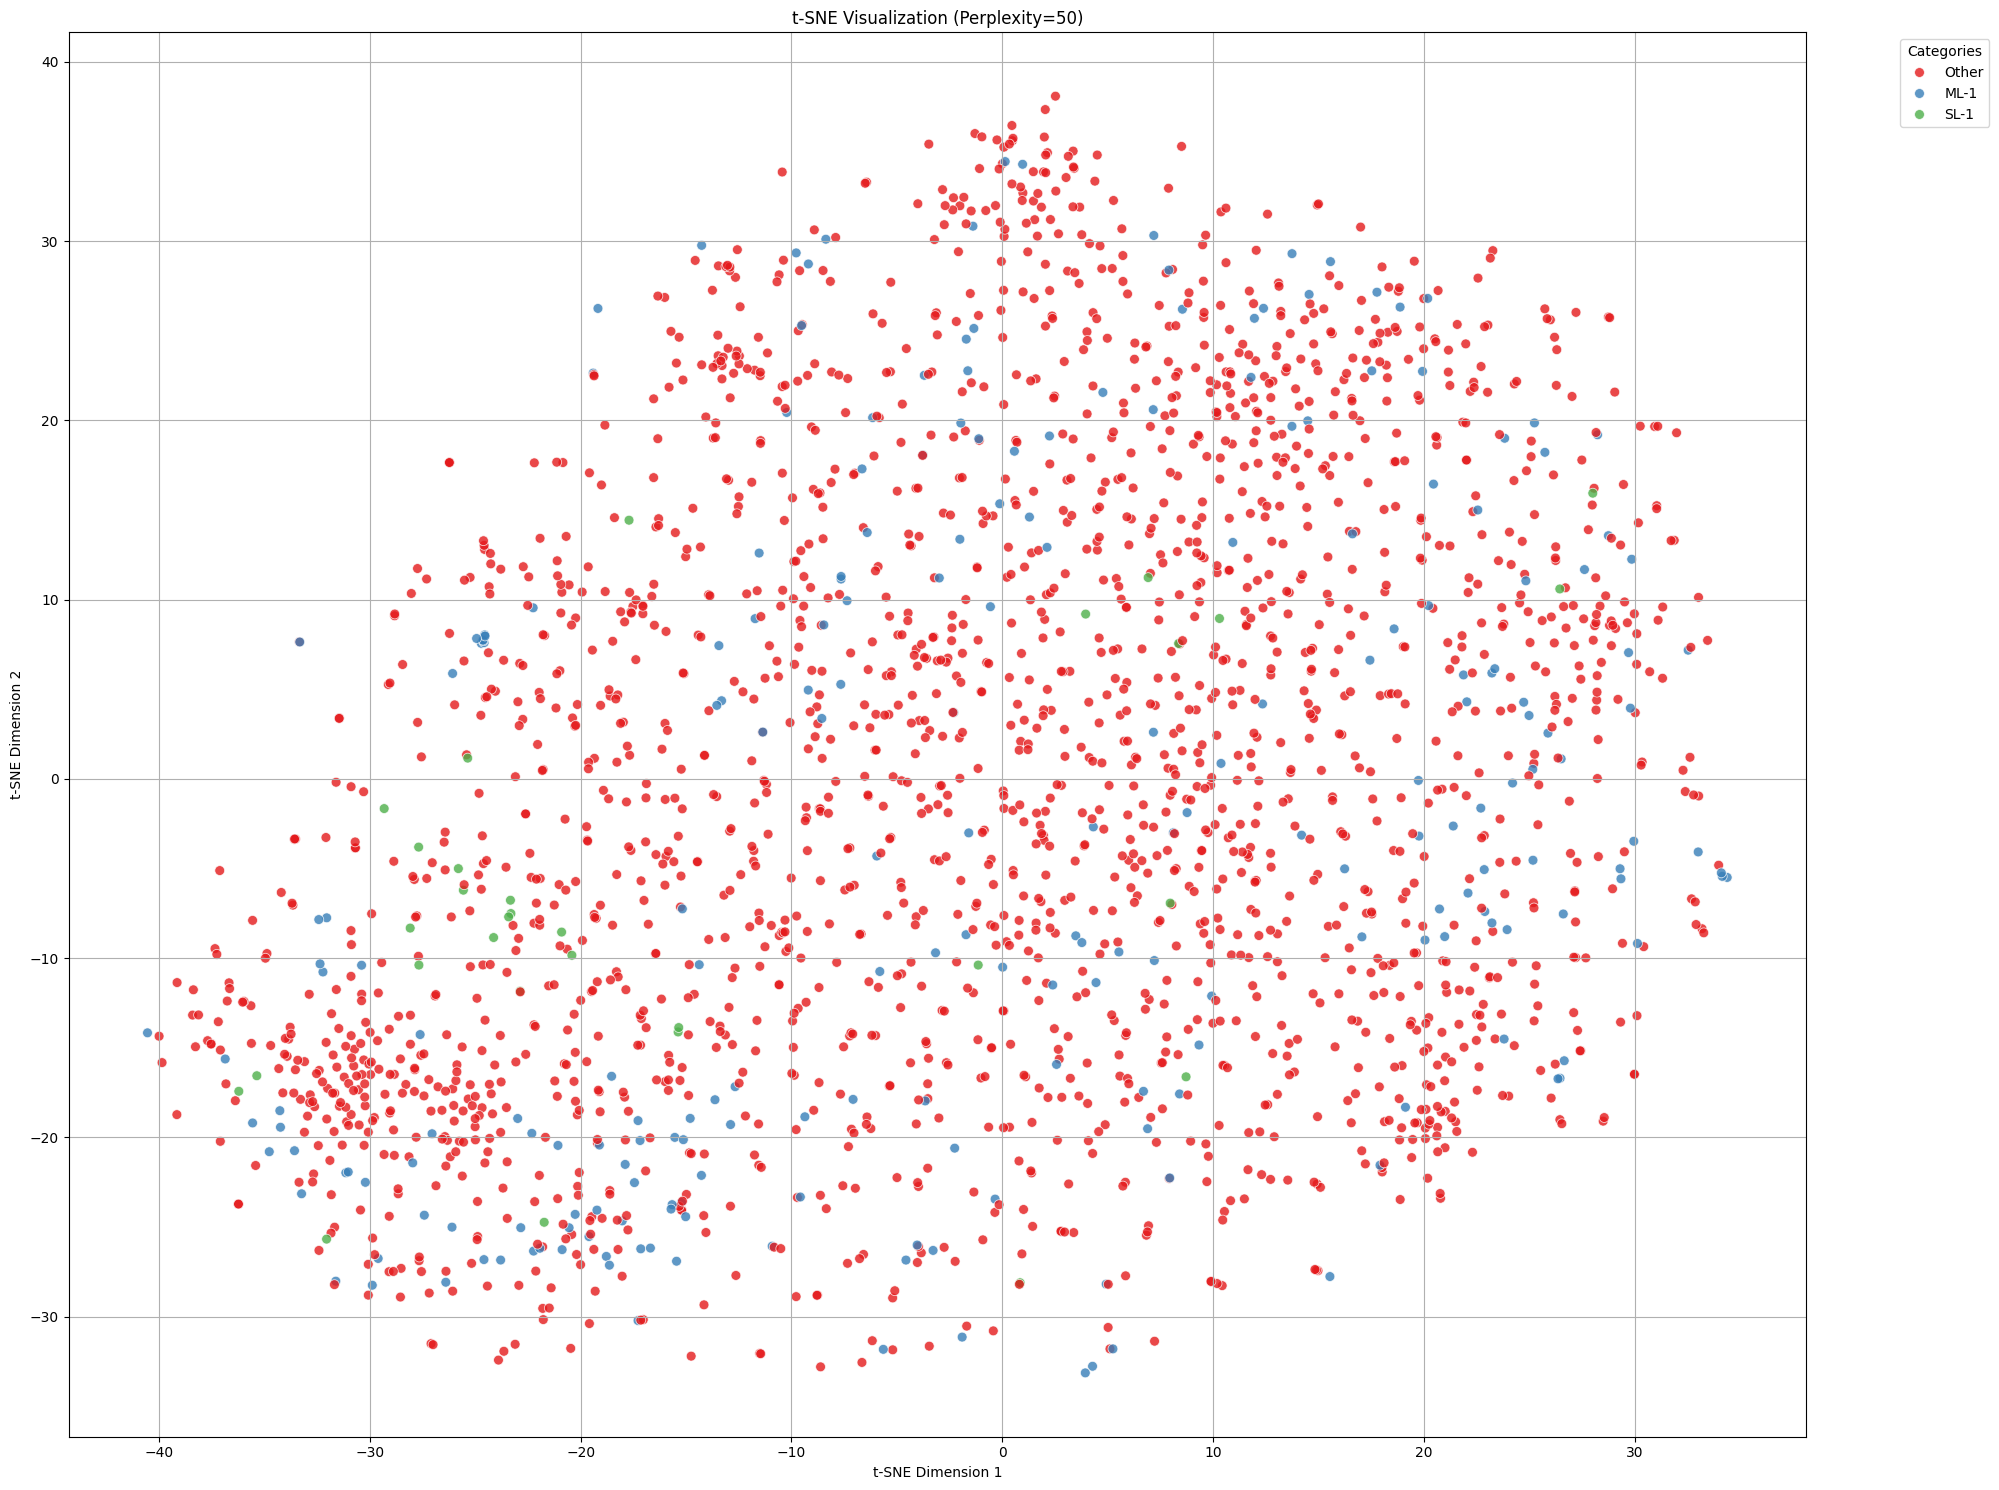

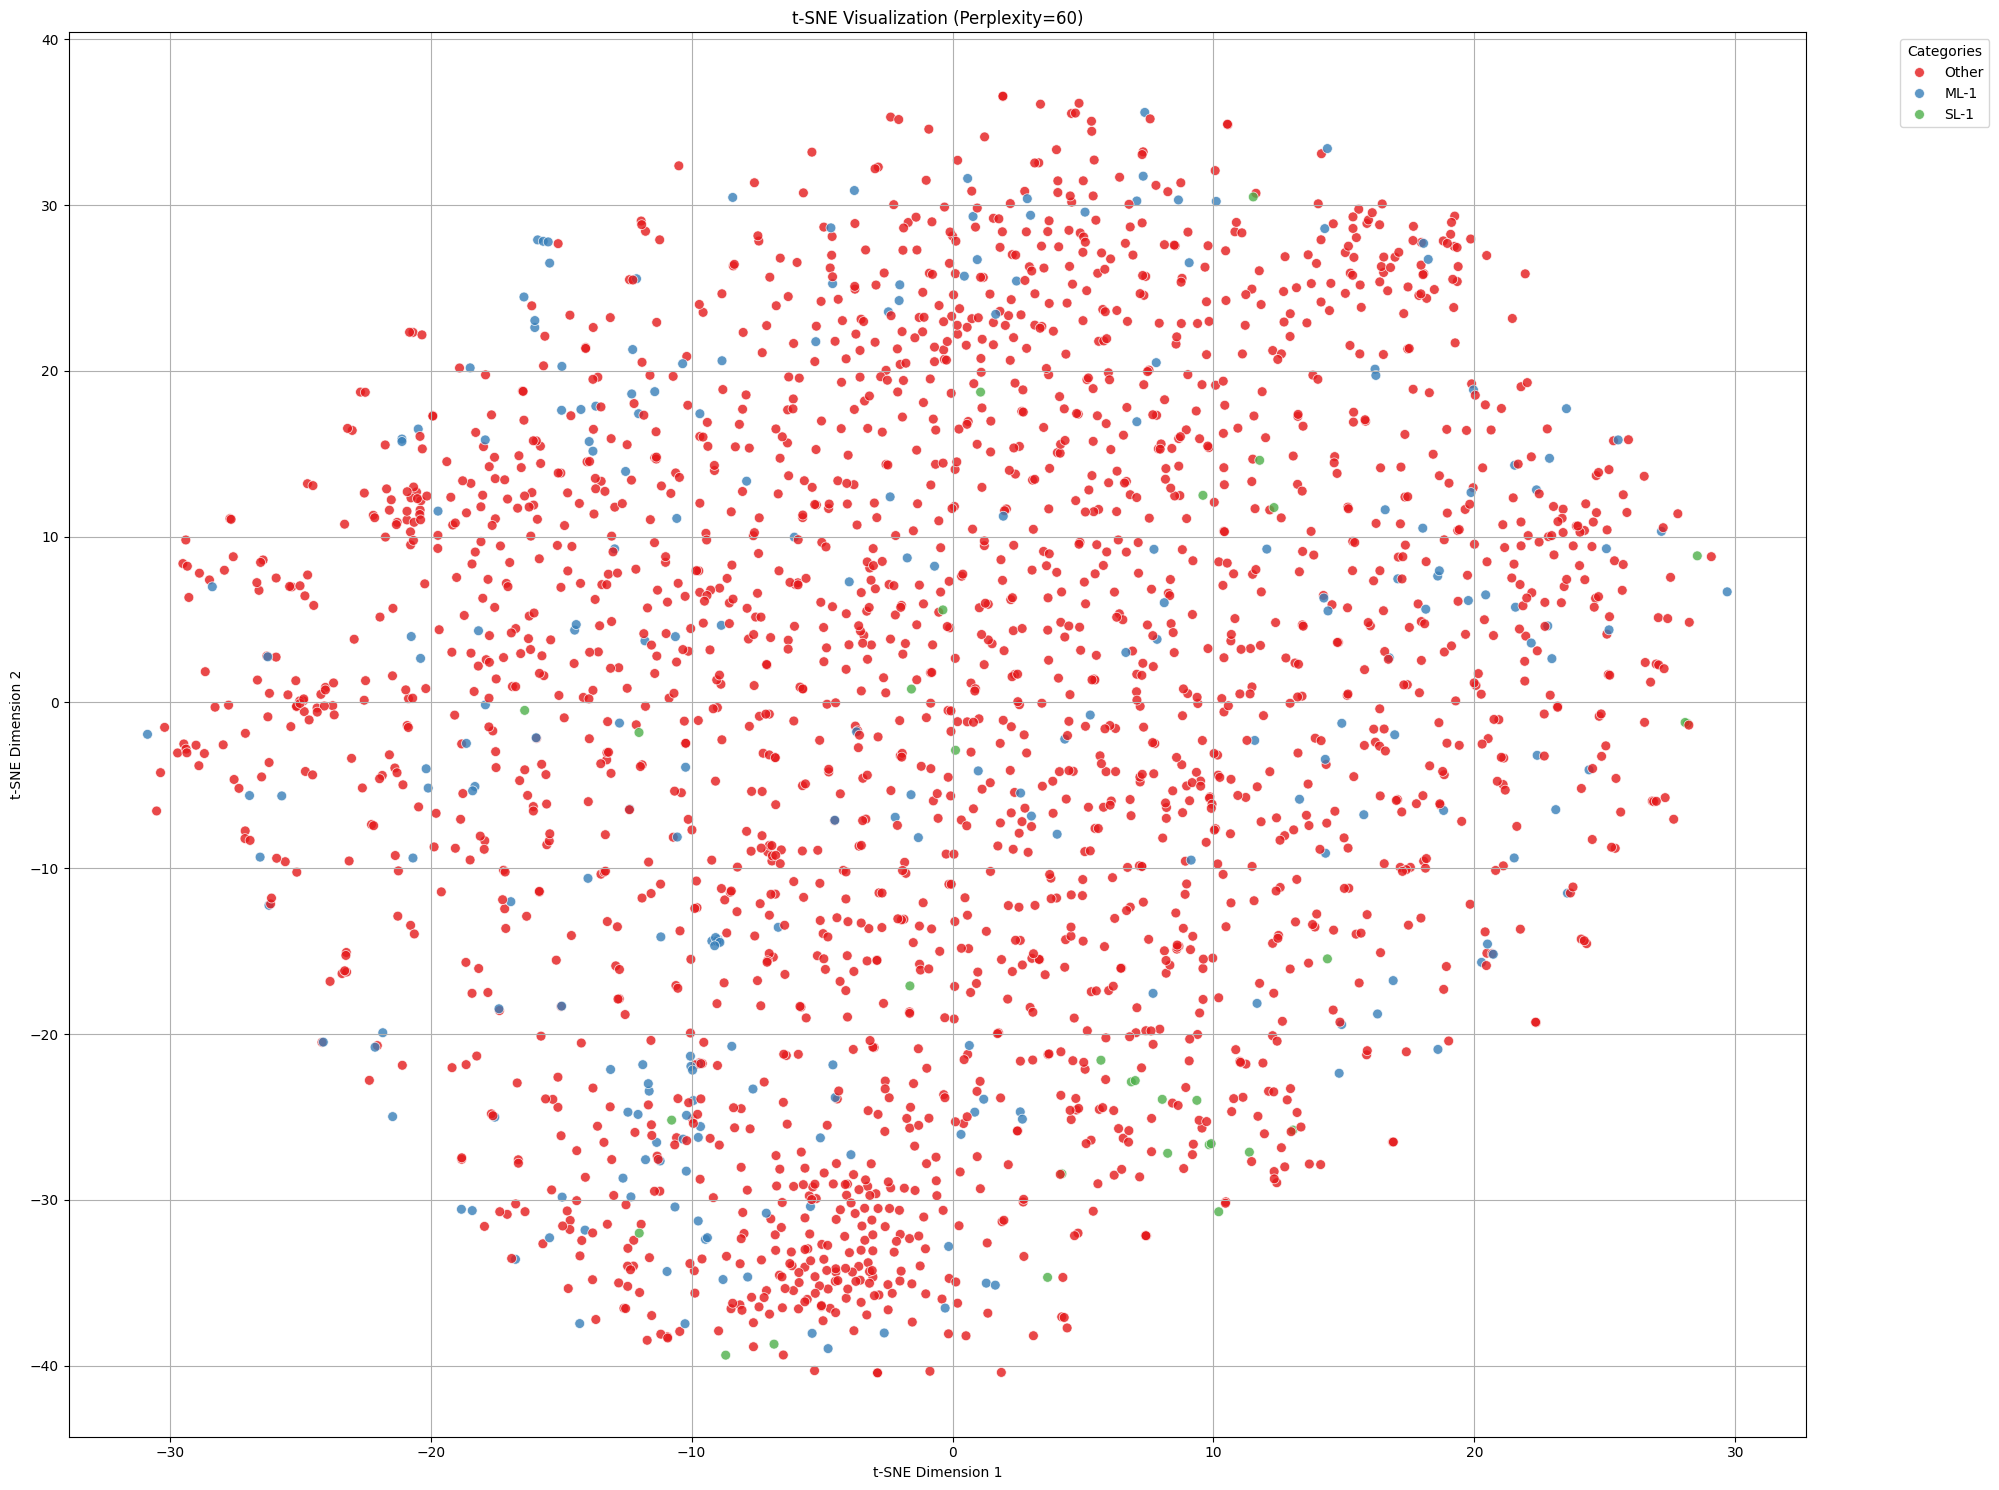

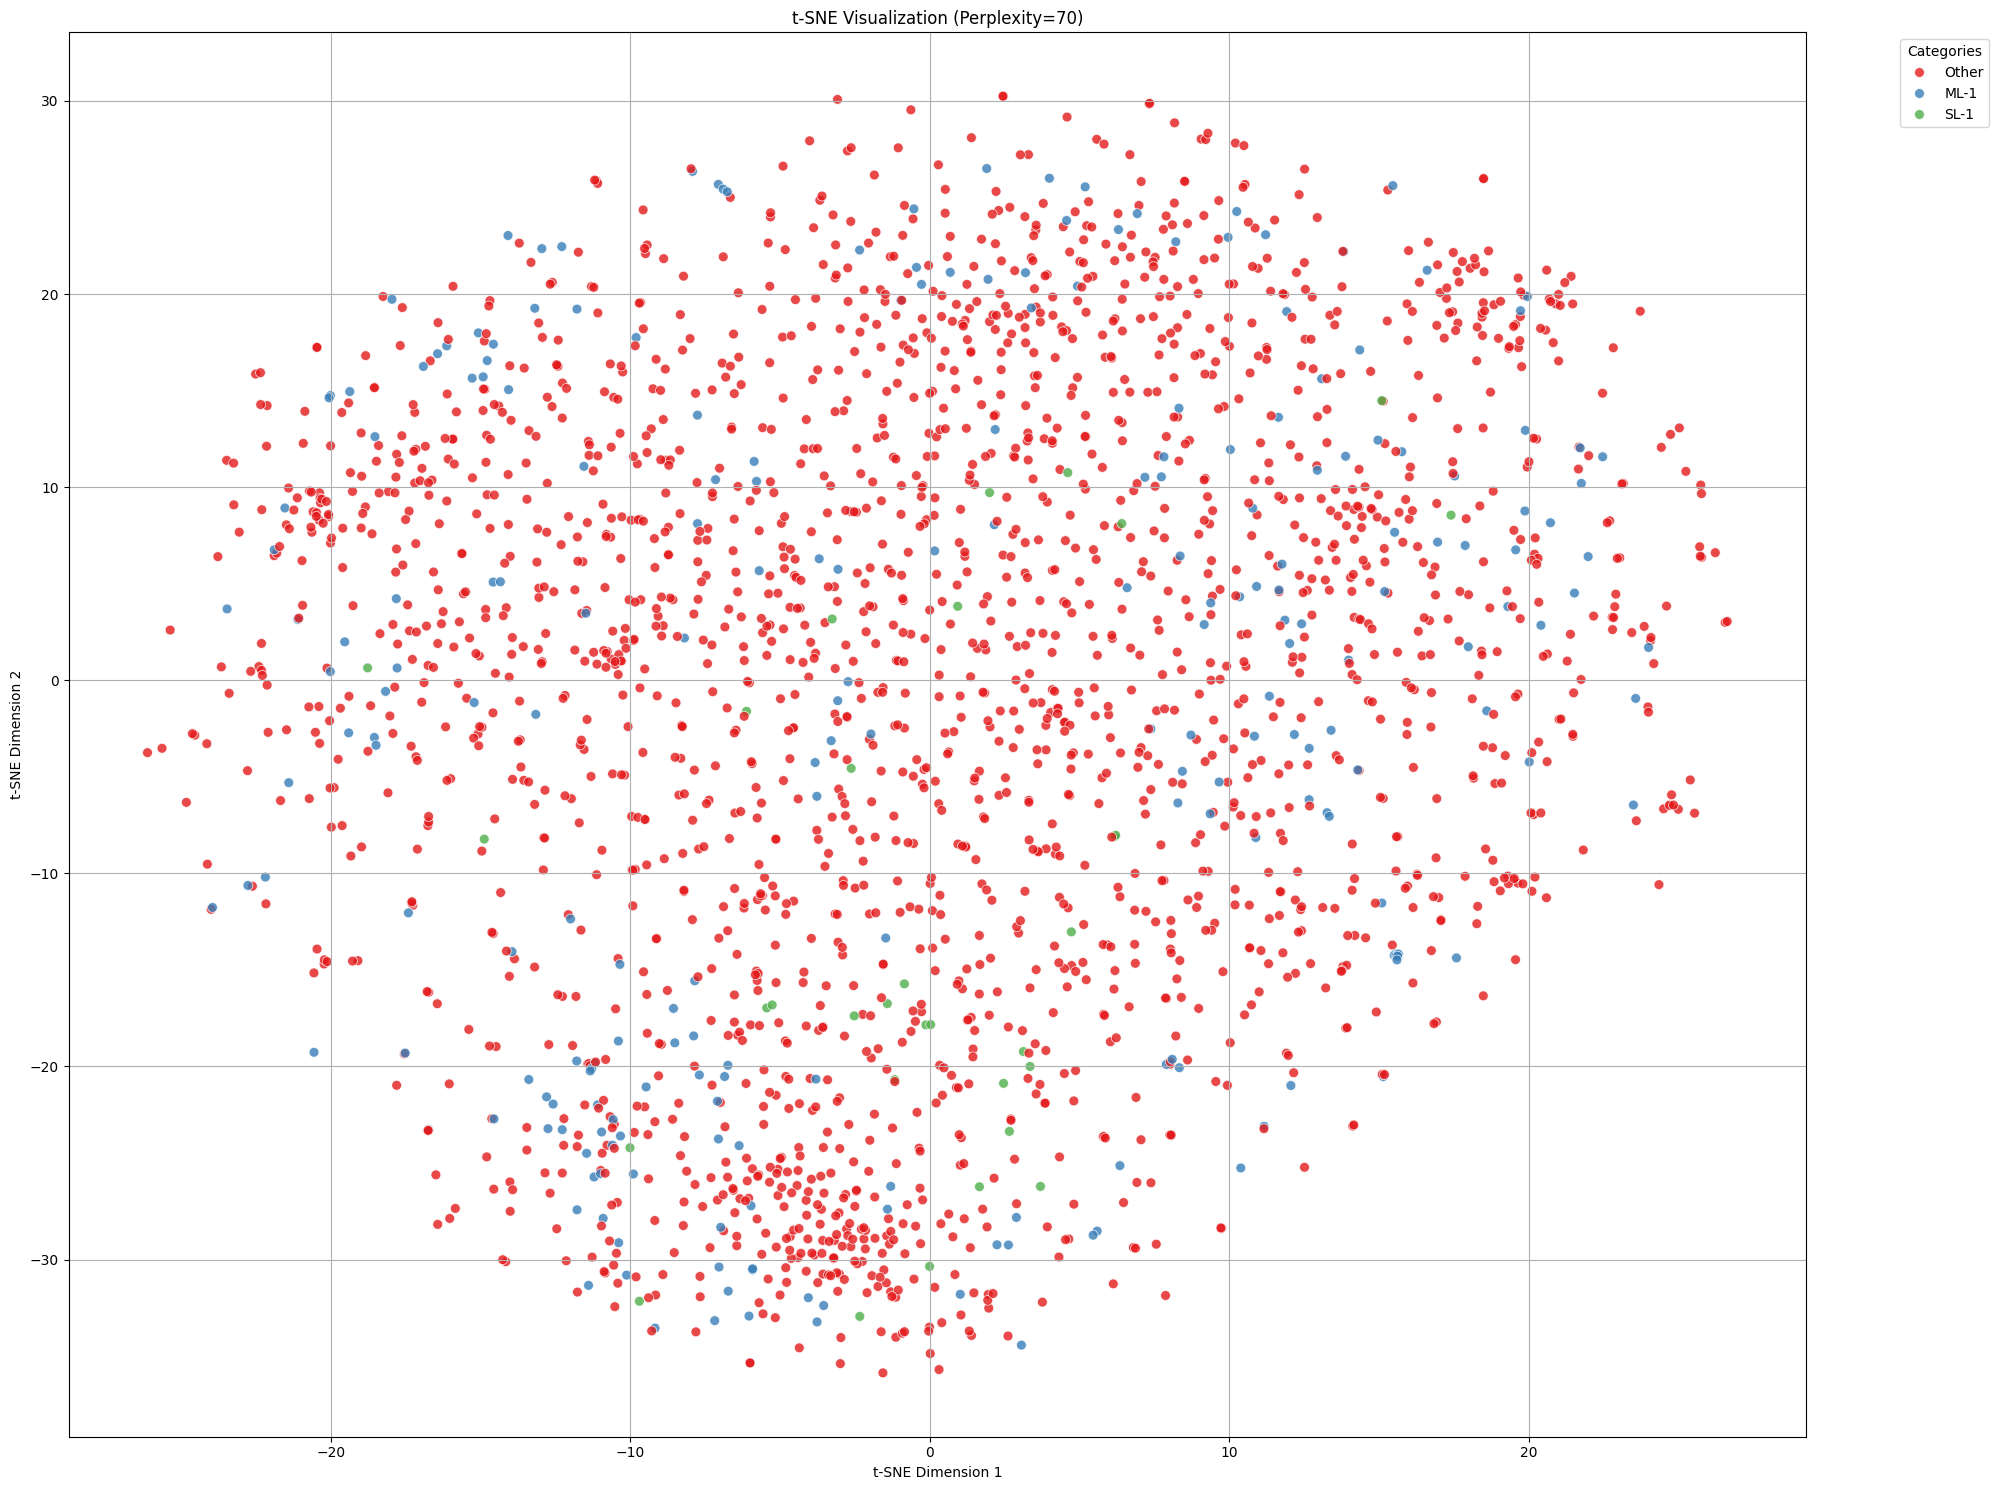

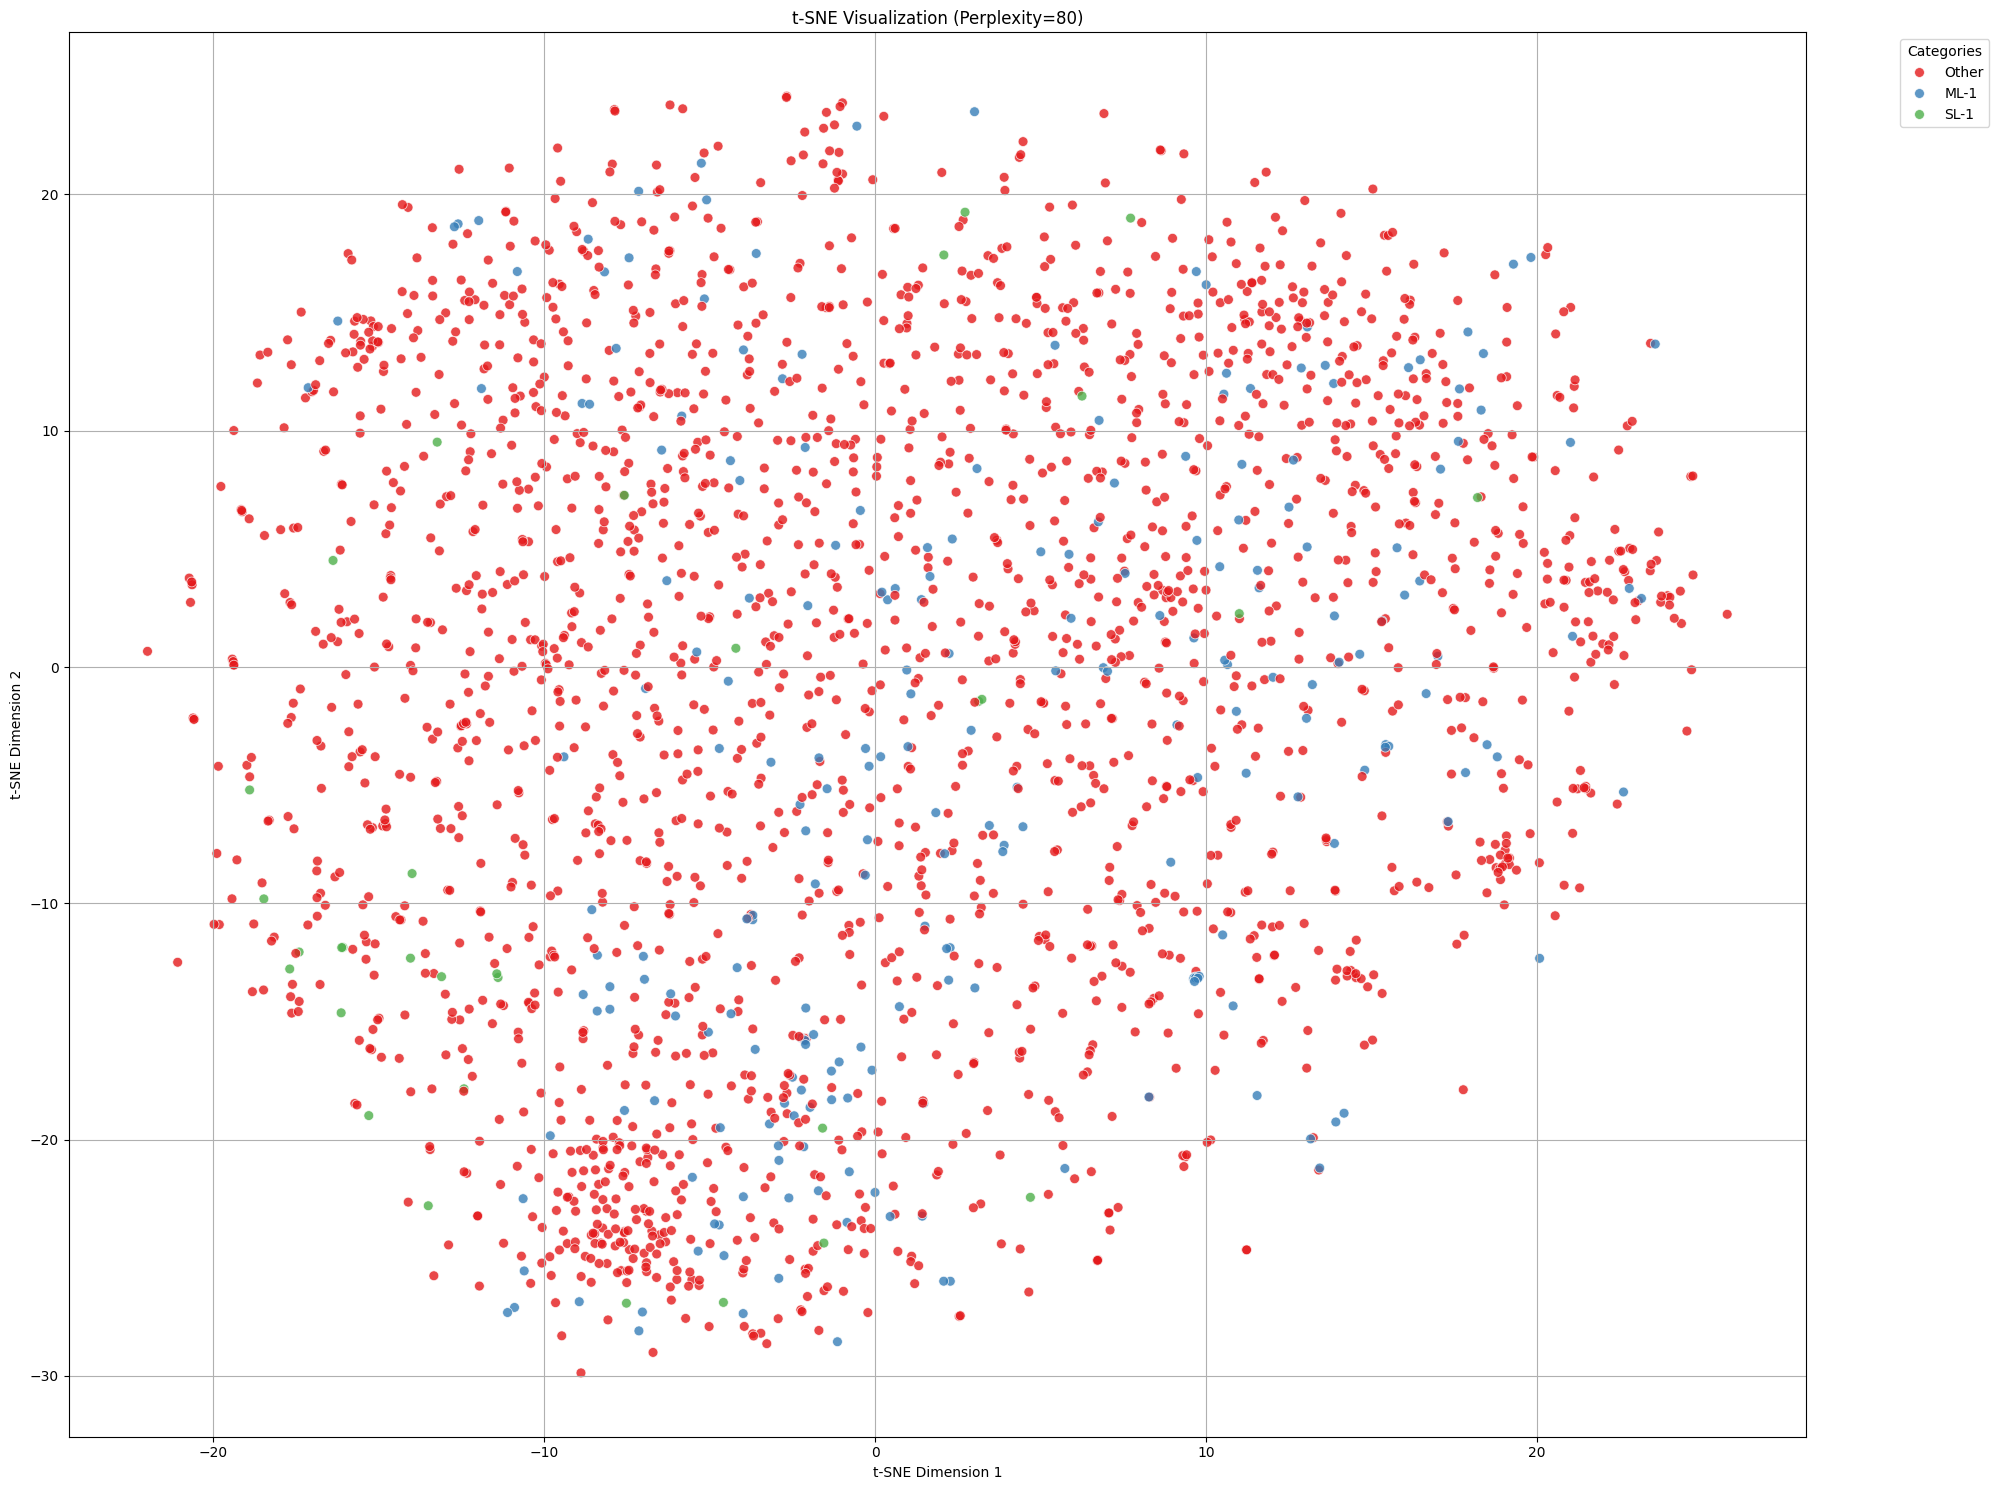

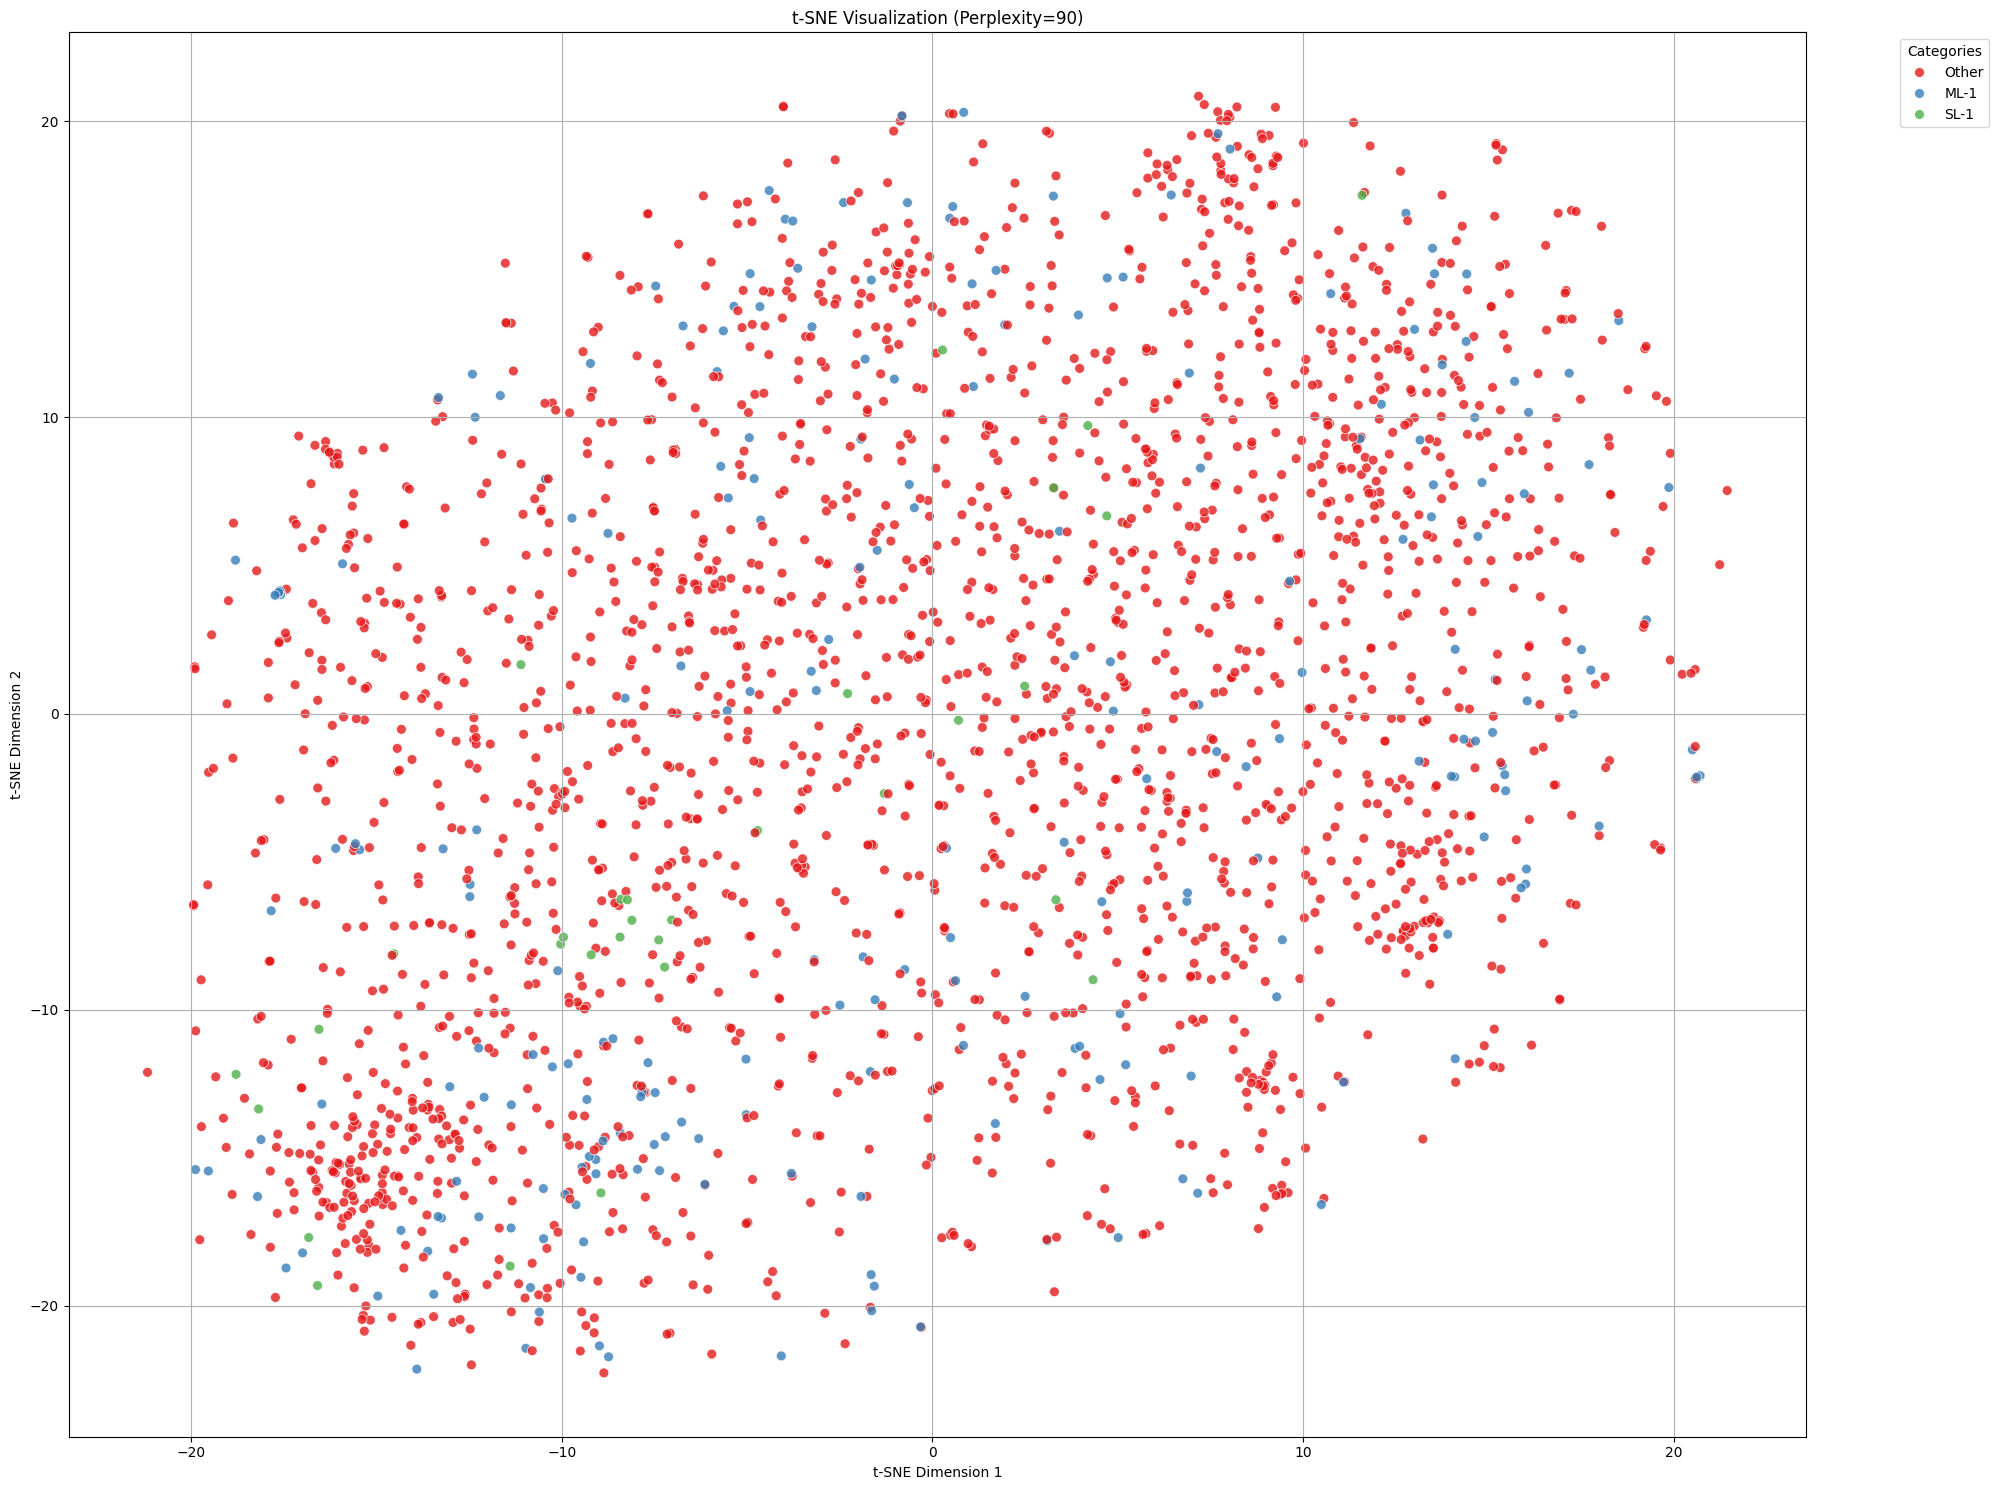

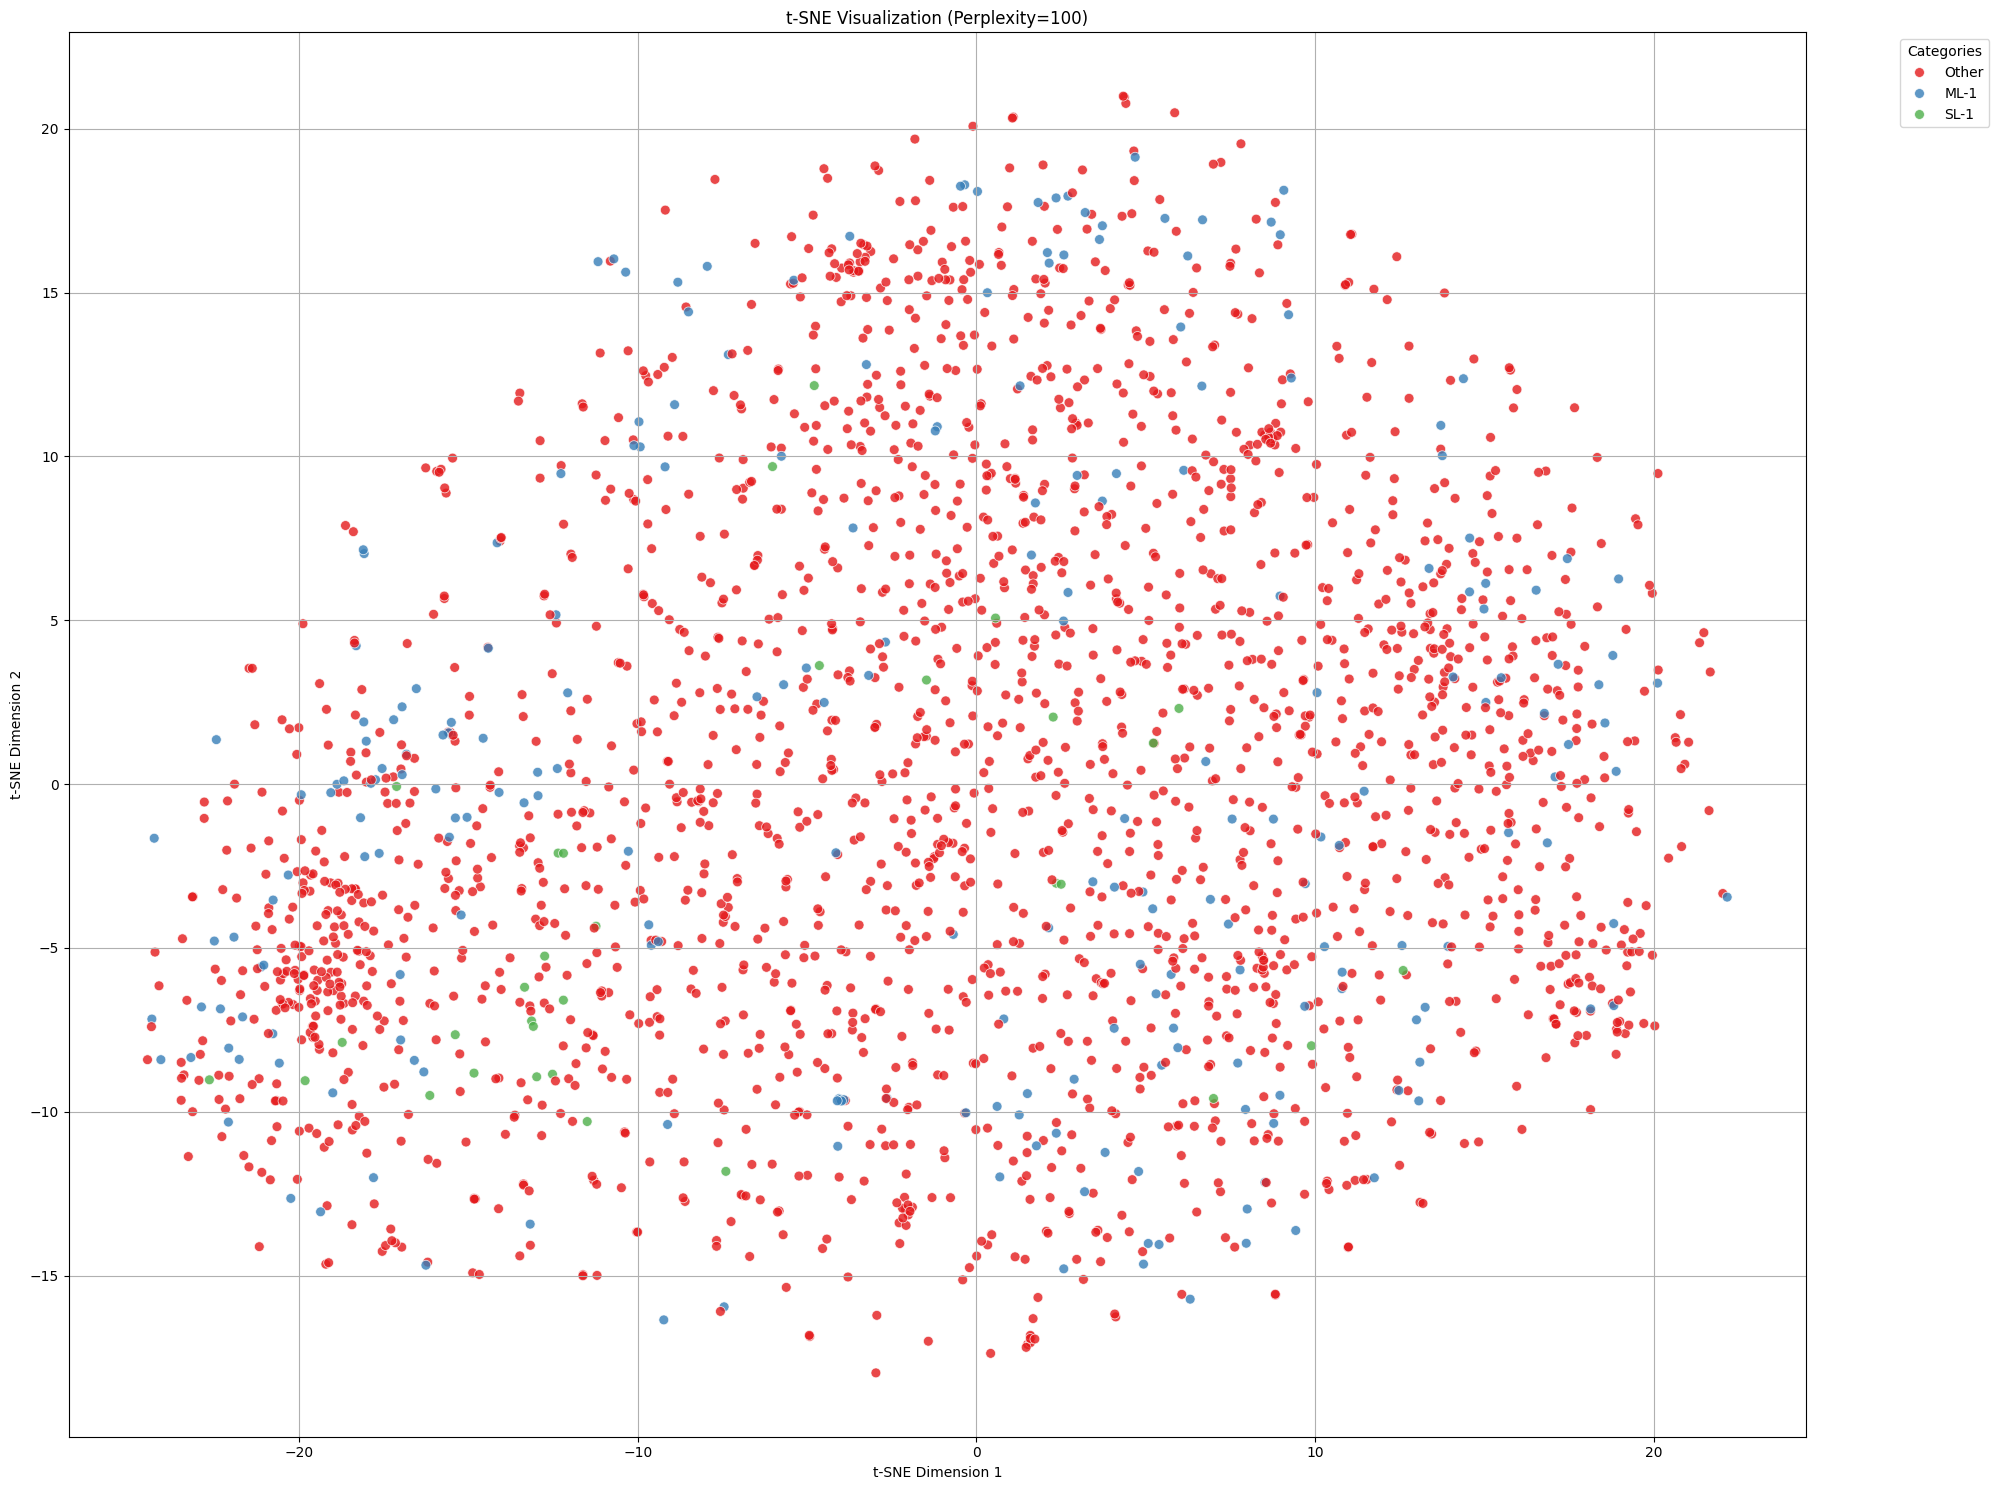

In [7]:
#plotting tsne results

for p, X_tsne in tsne_results.items():
    plt.figure(figsize=(20, 15))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=Y_new, palette='Set1', s=50, alpha=0.8)
    plt.title(f't-SNE Visualization (Perplexity={p})')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Perplexity
The ideal perplexity value balances preserving the local structure of the data (the relationships between nearest neighbors) and capturing the broader global arrangement of the main clusters. Since the goal is data veracity inspection, we need a plot that is neither too fragmented nor too merged. This is by nature a subjective analysis. Looking at the above plots:

### NLow Perplexity (P=5 and P=10)
SNE plots at low perplexity, such as P=5 and P=10, focus intensely on local neighborhoods. This results in a highly fragmented, "pointillistic" appearance. While these plots accurately emphasize very small, local differences, they tend to over-fragment larger, cohesive clusters, making the overall structure look noisy and chaotic. The global relationship between major categories is severely distorted, and it's difficult to distinguish real structure from noise artifacts.

#### High Perplexity (P=60 t0 P=100)
Conversely, plots generated with high perplexity  prioritize a more global view by considering a wider range of neighbors.This leads to significant merging and compression, especially evident in the P=100 plot, which appears as one dense mass. While this provides a smoother global view, it masks critical local details. This smoothing action makes it difficult to visually spot the key veracity issues, such as noisy/ambiguous labels (a specific point of one color embedded in a different cluster) and fine outliers, as these subtle neighborhood anomalies are simply absorbed into the larger, undifferentiated blobs.

#### Optimizing choice
From P=30 the plots significantly lose its pointillistic appearance. Clear local structures begin emerging at P=40, and become more apparent at P=50. Hence choosing 50.

This plot shows a stable, cohesive global structure (the main mass is maintained) while simultaneously preserving enough local detail. This ensures the major categories are clearly arranged, but the boundaries remain somewhat porous and the internal structure isn't excessively smoothed. This balance is crucial because it allows us to clearly identify intermingling at boundaries (hard-to-learn samples) due to the local detail. Simultaneously it enables us to spot embedded noisy labels without the overall picture being distorted, as the main clusters are still defined.

Running t-SNE with perplexity=50...
Completed run for P=50. Shape: (2417, 2)
Completed run for P=50. Shape: (2417, 2)


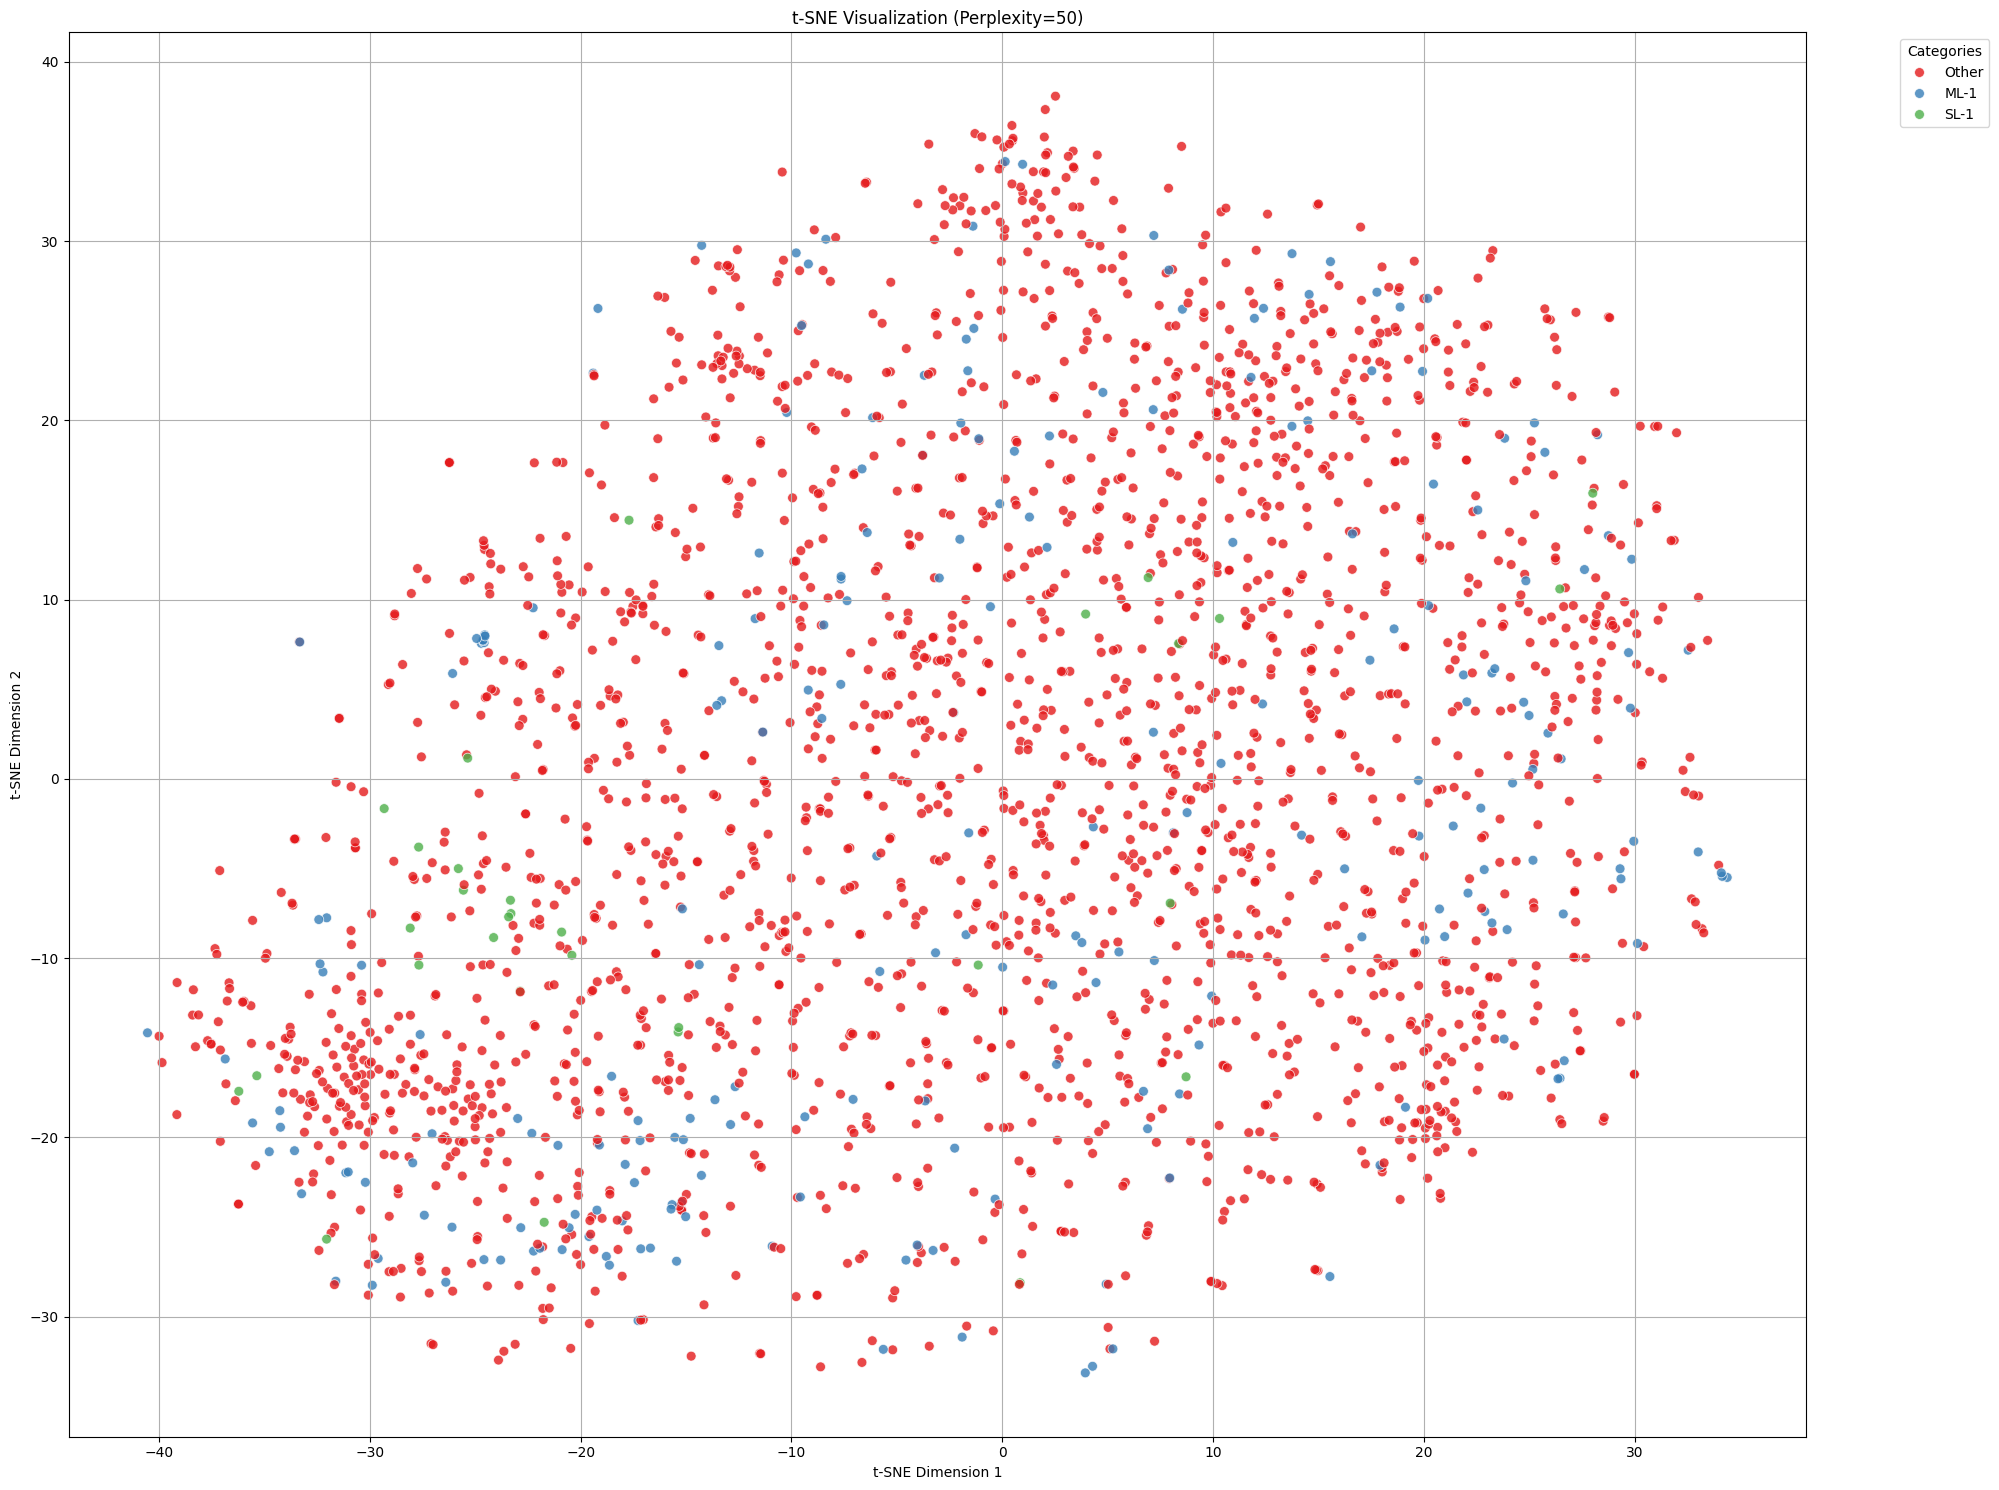

In [8]:
p=50
tsne = TSNE(n_components=2, perplexity=p, random_state=RANDOM_STATE, n_jobs=-1, learning_rate='auto', init='random')
print(f"Running t-SNE with perplexity={p}...")
X_tsne = tsne.fit_transform(X_scaled)
tsne_results[p] = X_tsne
print(f"Completed run for P={p}. Shape: {X_tsne.shape}")

plt.figure(figsize=(20, 15))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=Y_new, palette='Set1', s=50, alpha=0.8)
plt.title(f't-SNE Visualization (Perplexity={p})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Analysis of Data Veracity

#### Noisy or Ambiguous Labels  
These are characterized by instances where one color is deeply embedded within a cluster of a different color. In the plot, multiple cases appear, particularly within the large, diffuse clusters belonging to the **Other (Red)** category, where **ML-1 (Blue)** points are completely surrounded or embedded. This phenomenon extends beyond cluster boundaries into the perceived core of the red clusters.  

The gene expression features (all 103 of them) for these ML-1 samples resemble their Other neighbors so closely that they are drawn into the same local neighborhood. This suggests two possible explanations:

1. **Misclassification**: The assigned ML-1 label is incorrect, and the gene’s true function aligns more closely with the Other category.  
2. **Overlapping Functionality**: The gene’s function spans categories, making its expression profile indistinguishable from the Other group. In this case, confusion is inevitable for any classifier.

---

#### Outliers (Isolated Points or Tiny, Distant Clusters)  
Visual inspection reveals several single, highly isolated data points located far from the main data mass, often at the extreme edges of the plot. Most of these belong to the **Other (Red)** category.  

These outliers may represent:

1. **Technical Anomalies**: Experimental errors such as contamination with foreign DNA or instrument malfunctions, resulting in abnormally high or low signals across the 103 genes.  
2. **Extremely Rare Biological Events**: Gene expression profiles representing highly unique or rare biological states that do not resemble any known functional group in the dataset.  

For classifiers, these points appear novel and are unlikely to be generalized correctly.

---

#### Hard-to-Learn Samples (Thoroughly Mixed Categories)  
The central region of the t-SNE plot contains a dense cloud where **Other (Red)** and **ML-1 (Blue)** points are thoroughly mixed. Within this hub, there are no clear or discernible boundaries between categories.  

This region exemplifies hard-to-learn samples because it reflects significant decision uncertainty. In the original 103-dimensional space, these samples are approximately equidistant from multiple functional categories. As a result:

- **Simple classifiers**, such as linear models or k-Nearest Neighbors, cannot establish effective separating boundaries.  
- Since the gene expression features fail to provide local separability, any boundary a model attempts to draw would produce a high error rate.  
- Consequently, classifiers are forced to guess labels in this region, leading to poor predictive performance.

---


--- Running Isomap ---
Isomap completed.
Isomap X shape: (2417, 2)
Isomap completed.
Isomap X shape: (2417, 2)


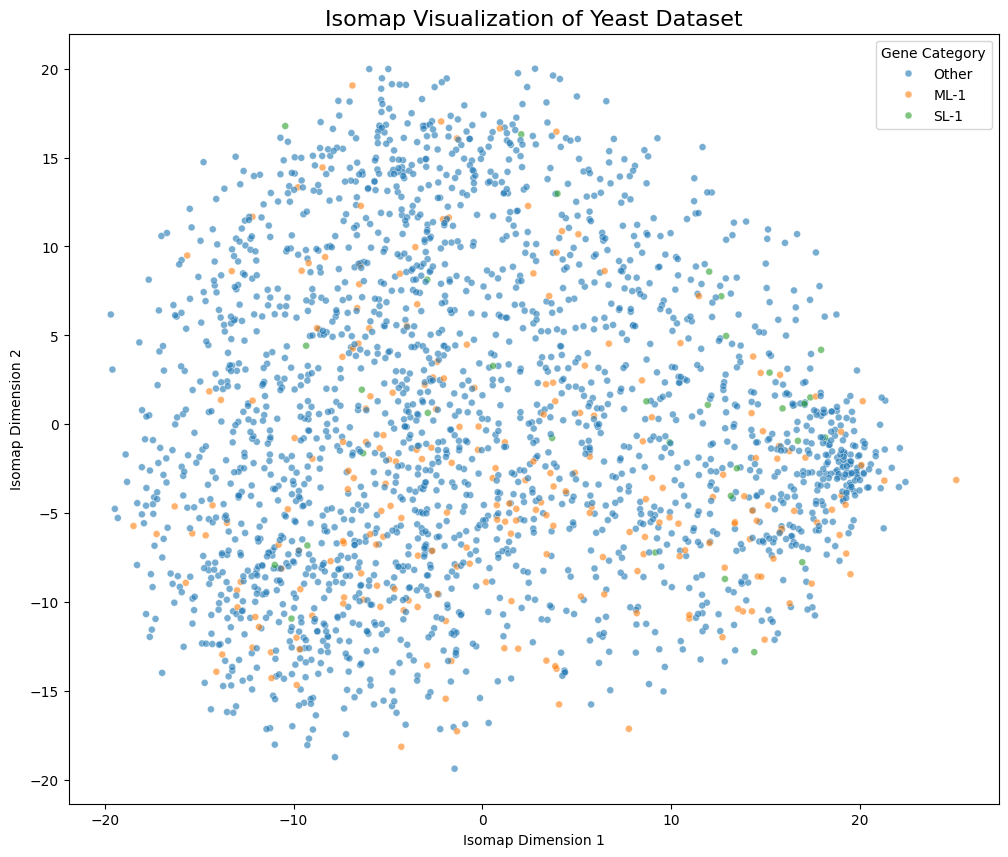

In [9]:
print("--- Running Isomap ---")

# Apply Isomap. The 'n_neighbors' is the critical hyperparameter here.
# A common starting point is 5-10 times the number of dimensions we are reducing to (2), 

isomap = Isomap(n_components=2, n_neighbors=15, n_jobs=-1) 
X_isomap = isomap.fit_transform(X_scaled)

print("Isomap completed.")
print(f"Isomap X shape: {X_isomap.shape}")

# Create a DataFrame for easy plotting
isomap_df = pd.DataFrame(X_isomap, columns=['Isomap-1', 'Isomap-2'])
isomap_df['Category'] = Y_new


# Define a consistent palette
unique_categories = isomap_df['Category'].unique()
palette = sns.color_palette("tab10", len(unique_categories))
category_colors = {cat: palette[i] for i, cat in enumerate(unique_categories)}

plt.figure(figsize=(12, 10))
sns.scatterplot(
    x="Isomap-1", y="Isomap-2",
    hue="Category",
    palette=category_colors,
    data=isomap_df,
    legend="full",
    alpha=0.6,
    s=25
)
plt.title('Isomap Visualization of Yeast Dataset', fontsize=16)
plt.xlabel('Isomap Dimension 1')
plt.ylabel('Isomap Dimension 2')
plt.legend(title='Gene Category', loc='best')
plt.show()




### Isomap vs. t-SNE
The core distinction between Isomap and t-SNE is based entirely on which data structure they prioritize during the dimensionality reduction process: Isomap focuses on the global structure, while t-SNE focuses fiercely on the local structure. Isomap achieves its global preservation by modeling the underlying data manifold—the true, curved shape on which the high-dimensional data is assumed to lie—and calculating geodesic distances. Instead of using the straight-line Euclidean distance, Isomap measures the shortest path between points along that manifold. This powerful mechanism makes Isomap better at revealing the holistic shape and connectivity of the gene expression profiles, clearly showing the overall spatial relationships between far-apart functional categories.

Conversely, t-SNE uses probabilistic modeling to strictly preserve local neighborhoods. It minimizes the difference between the probability distributions of neighbor relationships in the original 103-dimensional space and the resulting 2D map. This optimization results in highly distinct, tight clusters and is excellent for forcing clear separation between classes. Consequently, t-SNE is the superior tool for visualizing local density and cluster separation, w for the detailed inspection of data veracity issues like identifying noisy labels embedded deep within foreign clusters or pinpointing hard-to-learn mixed regions. 

### Comparison and Curvature Analysis

#### Isomap vs. t-SNE: Global Structure  
The two methods provide contrasting perspectives on the structure of the data.  

**t-SNE** produces highly separated, fragmented clusters with large empty voids between them. This approach is excellent for highlighting local separations but distorts the global geometry. The vast empty regions in the t-SNE plot do not reflect actual distances in the 103-dimensional feature space.  

**Isomap**, in contrast, depicts the data as a single, continuous, and highly structured mass. By preserving geodesic distances (distances along the intrinsic data curve), it reveals how the entire dataset is connected. This perspective shows that categories are not truly isolated clusters but are linked along a complex trajectory of gene expression profiles.

---

#### Data Manifold  
The data manifold represents the low-dimensional surface embedded within the high-dimensional feature space on which the data naturally resides. Manifold learning algorithms attempt to unfold this surface in order to reveal the true structure of the data.

---

#### Relating Complexity to Classification Difficulty  
The Isomap plot indicates that the yeast gene expression data lies on a highly curved and complex manifold. The distribution of points does not resemble a flat plane or a straight line; instead, it forms a twisted and folded surface with non-linear density variations.  

This curvature introduces major challenges for classification:

1. **Non-Linear Separability**  
   Simple classifiers, such as linear Support Vector Machines or Logistic Regression, attempt to separate classes using flat hyperplanes. When the true separation boundary between ML-1 and Other categories follows a complex, curved path along the manifold, flat boundaries lead to significant misclassification.  

2. **Distance Distortion**  
   On a curved manifold, relationships between gene expressions are non-Euclidean. Linear models implicitly assume Euclidean distances, which causes poor generalization. Accurate classification in this setting requires non-linear models, such as Random Forests or Neural Networks, which are capable of learning and approximating the curved decision surfaces necessary to correctly classify yeast genes.  

---
